# Chapter 2 端到端机器学习项目

**机器学习主要步骤**：

1. 着眼大局。
2. 获取数据。
3. 探索并可视化数据，以获得深刻的见解。
4. 为机器学习算法准备数据。
5. 选择一个模型并对其进行训练。
6. 微调模型。
7. 展示结果。
8. 启动、监视和维护系统。

## Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

## 1. 使用真实数据（Working with Real Data）

当你在学习机器学习时，最好是尝试真实世界的数据，而不是人工数据集。幸运的是，有成千上万的开放数据集可供选择，涵盖了各种领域。以下是一些你可以寻找获得数据的地方：

1. **流行的开放数据存储库**：OpenML.org、Kaggle.com、PapersWithCode.com、UC Irvine Machine Learning Repository、Amazon’s AWS datasets、TensorFlow datasets。
2. **元门户（列出了开放数据目录）**：DataPortals.org、OpenDataMonitor.eu。
3. **其他页面列出了许多流行的开放数据存储库**：Wikipedia’s list of machine learning datasets、Quora.com、The datasets subreddit。

在本章中，我们将使用来自StatLib存储库的加州房价数据集。

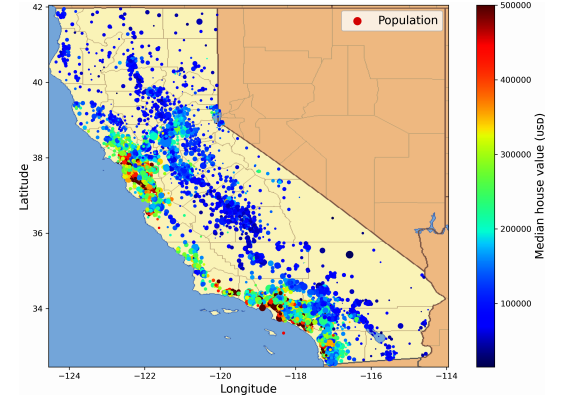

这个数据集是基于1990年加州人口普查的数据。它并不是最近建成的（旧金山湾区的一所好房子在当时仍然可以买得起），但它有很多学习的品质，所以我们会假装它是最近建成的数据。为了达到教学目的，添加了一个分类属性，并删除了一些特性。

## 2. 着眼大局（Look at the Big Picture）

欢迎来到机器学习住房公司！你的第一个任务是利用加州的人口普查数据来建立该州的房价模型。这些数据包括了加州每个街区群体的人口、收入中位数和房价中位数等指标。街区组是美国人口普查局发布样本数据的最小的地理单位（一个街区组通常有600到3000人）。

你的模型应该从这些数据中学习，并能够通过给定所有其他指标预测任何地区的房价中位数。

### 2.1 构件问题框架（Frame the Problem）

你要问你老板的第一个问题是，你的商业目标到底是什么。建立一个模型可能不是最终的目标。该公司期望如何使用和受益于这种模式？了解目标是很重要的，因为它将决定您如何构建问题，您将选择哪些算法，您将使用哪些性能度量来评估您的模型，以及您将花费多少精力来调整它。

你的老板回答说，你的模型的输出（对一个地区房价中值的预测）将被输入到另一个机器学习系统，以及许多其他信号。这个下游系统将决定是否值得在特定领域投资。正确地做到这一点至关重要，因为它会直接影响到收入。

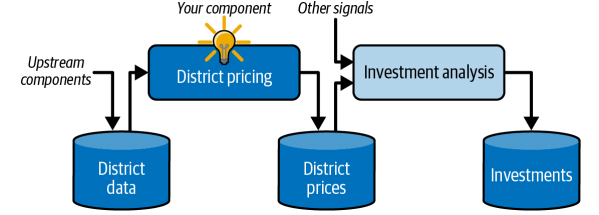

下一个要问你的老板的问题是，当前的解决方案是什么样子的（如果有的话）。当前的情况通常会为您提供性能参考，以及关于如何解决问题的见解。你的老板回答说，目前地区房价是由专家手动估算的：一个团队收集一个地区的最新信息，当他们不能得到房价中位数时，他们使用复杂的规则来估算。

这是昂贵和耗时的，并且他们的估计并不好；在他们设法找出实际房价中位数的情况下，他们经常意识到他们的估计下降了30%以上。这就是为什么该公司认为，根据有关一个地区的其他数据，训练一个模型来预测该地区的房价中位数将是有用的。人口普查数据看起来像是一个很好的数据集，因为它包括了数千个地区的房价中位数，以及其他数据。

**管道/流水线（pipeline）**：数据处理组件的序列被称为数据管道。管道在机器学习系统中非常常见，因为有大量的数据需要操作，还有许多数据转换需要应用。组件通常以异步运行。每个组件接收大量的数据，处理它，并将结果输出到另一个数据存储中。然后，一段时间后，管道中的下一个组件提取这个数据并输出自己的输出。每个组件都是相当独立的：组件之间的接口只是数据存储。这使得系统易于掌握（在数据流图的帮助下），不同的团队可以专注于不同的组件。此外，如果一个组件出现故障，下游组件通常可以通过只使用损坏组件的最后一个输出来继续正常运行（至少运行一段时间）。这使得该体系结构相当健壮。另一方面，如果没有实施适当的监视，一个损坏的组件可能会在一段时间内被忽视。数据陈旧，整个系统的性能下降。

有了所有这些信息，您现在就可以开始设计您的系统了。首先，确定该模型需要什么样的训练监督：它是有监督、无监督、半监督、自我监督还是强化学习任务？它是一个分类任务，一个回归任务，还是其他什么东西？你应该使用批量学习还是在线学习技术吗？在你继续阅读之前，先停下来，试着自己回答这些问题。

让我们看看。这显然是一个典型的监督学习任务，因为该模型可以用带有标记的例子进行训练（每个实例都带有预期的产出，即该地区的房价中位数）。这是一个典型的回归任务，因为该模型将被要求预测一个值。更具体地说，这是一个多元回归问题，因为该系统将使用多个特征来进行预测（该地区的人口、中位数收入等）。这也是一个单变量回归问题，因为我们只试图预测每个地区的一个值。如果我们试图预测每个地区的多个值，这将是一个多元回归问题。最后，没有连续的数据流进入系统，没有特别需要调整快速变化的数据，数据足够小以适应内存，所以普通的批学习应该做得很好。

**注意**：如果数据很大，您可以将批处理学习工作跨多个服务器进行分割（使用MapReduce技术）或使用在线学习技术。

## 2.2 选择性能度量（Select a Performance Measure）

您的下一步是选择一个性能度量值。回归问题的一个典型性能度量是均方根误差（RMSE）。它给出了系统在预测中通常产生多少误差的概念，给大误差更高的权重。

**均方根误差（Root mean square error）**：

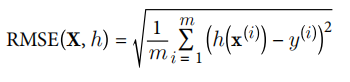

**常见机器学习符号说明**：

1. $m$ 是正在测量RMSE的数据集中的实例数。例如，如果您正在一个包含2000个地区的验证集上评估RMSE，那么 $m=2000$ 。
2. $\pmb{x}^{(i)}$ 是数据集中第 $i$ 个实例的所有特征值（不包括标签）的向量，而 $y^{(i)}$ 是它的标签（该实例所需的输出值）。例如，如果数据集中的第一个地区位于经度-118.29°，纬度33.91°，并且它有1416名居民，收入中位数为38372美元，而房价中位数为156400美元（目前忽略其他特征），那么：$$\pmb{x}^{(l)}= \begin{pmatrix}
-118.29\\
33.91\\
1416\\
38372
\end{pmatrix}$$
并且 $y^{(l)}=156400$ 。
3. $\pmb{X}$ 是一个包含数据集中所有实例的所有特征值（不包括标签）的矩阵。每个实例有一行，第 $i$ 行等于 $\pmb{x}^{(i)}$ 的转置，记为 $(\pmb{x}^{(i)})^T$ 。例如，如果第一个区域如前面描述的那样，那么矩阵 $\pmb{X}$ 是这样的：
$$\pmb{X}= \begin{pmatrix}
(\pmb{x}^{(1)})^T\\
(\pmb{x}^{(2)})^T\\
\vdots\\
(\pmb{x}^{(1999)})^T\\
(\pmb{x}^{(2000)})^T
\end{pmatrix}=
\begin{pmatrix}
-118.29 & 33.91 & 1416 & 38372\\
\vdots & \vdots & \vdots & \vdots\\
\end{pmatrix}$$
4. $h$ 是系统的预测函数，也称为**假设（hypothesis）**。当系统给定一个实例的特征向量 $\pmb{x}^{(i)}$ 时，它将为该实例输出一个预测值 $\hat{y}^{(i)}=h(\pmb{x}^{(i)})$ 。例如，如果系统预测第一个地区的房价中值为158400美元，那么 $\hat{y}^(1)=h(\pmb{x}^{(1)})=158400$。该地区的预测误差为 $\hat{y}^{(1)}-y^{(1)}=2000$ 。
5. $RMSE(\pmb{X},h)$ 是使用假设 $h$ 在一组例子上测量的成本函数。


尽管RMSE通常是回归任务的首选性能度量，但在某些情况下，您可能更喜欢使用其他函数。例如，如果有许多离群区。在这种情况下，您可以考虑使用平均绝对误差(MAE，也称为平均绝对偏差），如公式所示：

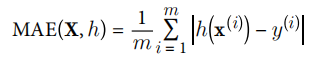

RMSE 和 MAE 都是测量两个向量之间距离的方法：预测向量和目标值向量。可以进行各种距离测量或规范：

1. 计算一个平方和的根（RMSE）对应于欧几里得范数：这是我们都熟悉的距离的概念。它也被称为 $ℓ2$ 规范，记作 $||\cdot||_2$ （或只是 $||\cdot||$ ）。
2. 计算绝对之和（MAE）对应于 $ℓ1$ 范数，记为 $||\cdot||_1$ 。这有时被称为曼哈顿规范，因为如果你只能沿着正交的城市街区旅行，它就会测量一个城市中两点之间的距离。
3. 更一般地，包含 $n$ 个元素的向量 $\pmb{v}$ 的 $ℓ_k$ 范数定义为 $||\pmb{v}||_k=(|v_1|^k+|v_2|^k+\cdots+||v_n||^k)^{1/k}$ 。$ℓ_0$ 给出向量中非零元素的个数，$ℓ_\infty$ 给出向量中的最大绝对值。

**注意**：范数指数越高，就越关注大值，越忽略小值。这就是为什么RMSE比MAE对异常值更敏感。但是，当异常值呈指数级罕见时（比如钟形曲线），RMSE表现得非常好，通常是首选。

### 2.3 检查假设（Check the Assumptions）

最后，列出并验证迄今为止（由你或其他人）已经做出的假设是一种很好的做法；这可以帮助你及早发现严重的问题。例如，您的系统输出的地区价格将会被输入到下游的机器学习系统中，并且您假设这些价格将会被这样使用。但是，如果下游系统将价格转换为类别（例如，“便宜”、“中等”或“昂贵”），然后使用这些类别而不是价格本身，会怎么样呢？在这种情况下，获得完全正确的价格一点也不重要；你的系统只需要得到正确的类别。如果是这样，那么这个问题就应该被定义为一个分类任务，而不是一个回归任务。你不想在在回归系统上工作了几个月后发现这一点。

幸运的是，在与负责下游系统的团队交谈之后，你确信他们确实需要实际的价格，而不仅仅是类别。伟大你都准备好了，灯是绿色的，你现在就可以开始编码了！

## 3. 获取数据（Get the Data）

### 3.1 下载数据（Download the Data）

在典型的环境中，您的数据将在关系数据库或其他一些公共数据存储中可用，并分布在多个表/文档/文件中。要访问它，您首先需要获取凭据和访问授权，并熟悉数据模式。然而，在这个项目中，事情要简单得多：您只需下载一个压缩文件，它包含一个逗号的分隔值（CSV）文件 housing.csv ，包含所有数据。

与其手动下载和解压缩数据，通常最好是编写一个适合您使用的函数。如果数据定期变化，这尤其有用：您可以编写一个使用该函数获取最新数据的小脚本（或者您可以设置一个计划作业以定期自动执行该任务）。如果您需要在多台机器上安装数据集，那么自动获取数据的过程也很有用。

下面是获取和加载数据的函数：

In [3]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="datasets")
    
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

当调用 load_housing_data() 时，它会查找 datasets/housing.tgz 文件。如果没有找到它，它将在当前目录中创建数据集目录（在Colab中默认为 /content ），从 ageron/data GitHub存储库中下载 housing.tgz 文件，并将其内容提取到数据集目录中；这将创建包含 housing.csv 文件的 datasets/housing 目录。最后，该函数将此CSV文件加载到一个包含所有数据的Pandas数据帧对象中，并返回它。

### 3.2 快速查看一下数据结构（Take a Quick Look at the Data Structure）

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


每一行代表一个街区。这里有10个属性：经度、纬度、住房中位数年龄、总房间、总卧室、人口、家庭、收入中位数、住房价值中位数和海洋邻近度。

**info()** 方法对于获得数据的快速描述非常有用，特别是总行数、每个属性的类型和非空值的数量：

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


数据集中有20,640个实例，这意味着按照机器学习的标准，它相当小，但它是完美的开始。注意到 total_bedrooms 属性只有 20433 个非空值，这意味着207个地区缺少这个特性。你之后需要处理这个问题。

所有的属性都是数字的，除了 ocean_proximity 。它的类型是 object ，因此它可以保存任何类型的Python对象。但是由于您从CSV文件加载此数据，您知道它必须是一个文本属性。当您查看前五行时，您可能会注意到 ocean_proximity 列中的值是重复的，这意味着它可能是一个分类属性。您可以通过使用 **value_counts()** 方法来找出存在哪些类别，以及每个类别有多少个地区：

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

让我们来看看其他的域。**describe()** 方法显示了一个数值属性的摘要：

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

另一种快速了解您正在处理的数据类型的方法是为每个数字属性绘制一个直方图。直方图显示了具有给定值范围（在水平轴上）的实例的数量（在垂直轴上）。您可以一次绘制这个属性，也可以在整个数据集上调用 **hist()** 方法（如下面的代码示例所示），它将为每个数字属性绘制一个直方图：

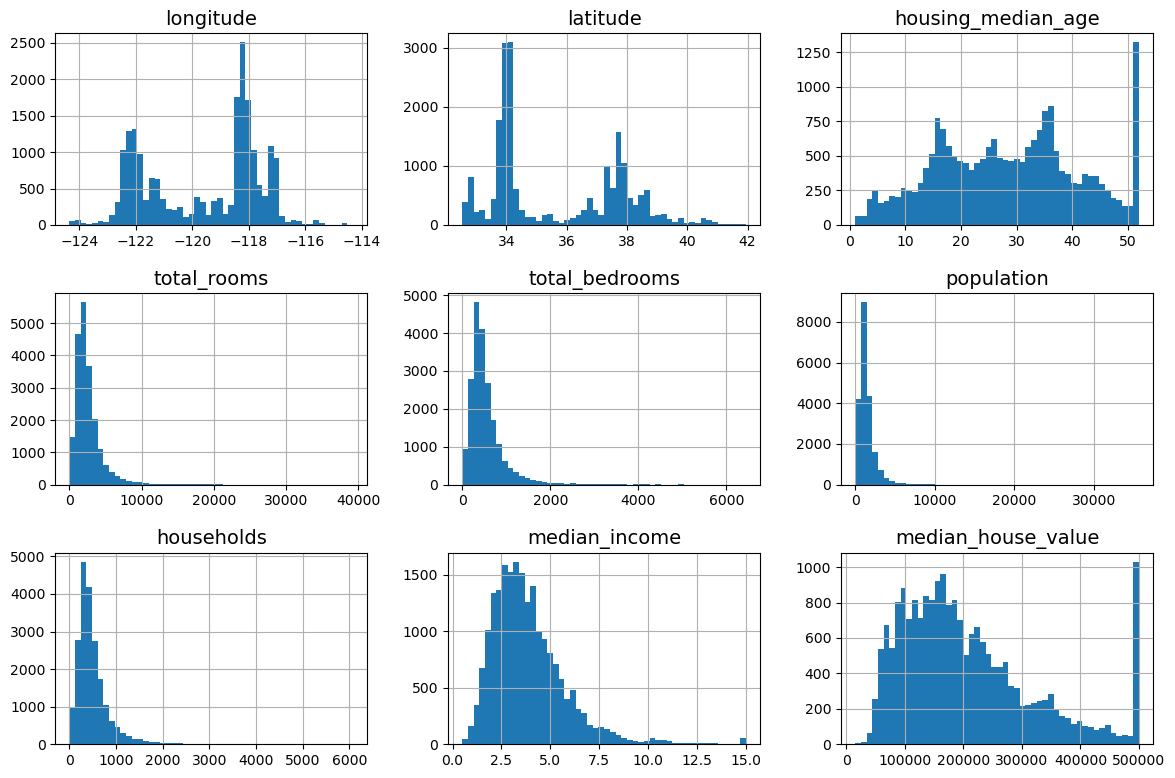

In [9]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))

save_fig("attribute_histogram_plots")  # extra code

plt.show()

看看这些直方图，你会注意到一些事情：

1. 首先，收入中值属性看起来不像是用美元（美元）表示的。在与收集数据的团队进行核对后，你会得知，高中位数的数据被调整为15（实际上为15.0001），低中位数的数据为0.5（实际上为0.4999）。这些数字大约代表了数万美元（例如，3 实际上意味着大约 3 万美元）。使用预处理后的属性在机器学习中很常见，但这并不一定是一个问题，但您应该尝试理解数据是如何计算的。
2. 住房中位数年龄和房屋价值中位数也有上限。后者可能是一个严重的问题，因为它是您的目标属性（您的标签）。你的机器学习算法可能会知道，价格永远不会超过这个极限。您需要与您的客户团队（将使用您的系统输出的团队）进行检查，看看这是否有问题。如果他们告诉你，他们需要精确的预测，即使超过50万美元，那么你有两个选择：为标签被封顶的地区收集适当的标签；从训练集中删除这些区域（也从测试集中删除，因为如果您的系统预测值超过50万美元，就不应该进行了糟糕的评估）。
3. 这些属性有非常不同的尺度。我们将在本章的后面讨论这个问题，届时我们将讨论特性缩放。
4. 最后，许多直方图都是向右倾斜的：它们向中间值的右边比向左延伸得要远得多。这可能会使一些机器学习算法更难检测模式。稍后，您将尝试将这些属性转换为具有更对称和钟形的分布。

### 3.3 创建测试集（Create a Test Set）

在这个阶段，自愿搁置部分数据似乎有些奇怪。毕竟，你只快速浏览了一下数据，在你决定使用什么算法之前，你当然应该了解更多，对吧？这是真的，但你的大脑是一个令人惊叹的模式检测系统，这也意味着它非常容易发生过拟合：如果你看了这个测试集，你可能会偶然发现一些在测试数据中看似有趣的模式，引导你选择一种特定类型的机器学习模型。当您使用测试集估计泛化错误时，您的估计将过于乐观，并且您将启动一个性能不如预期的系统。这被称为 **数据监听偏差（data snooping bias）** 。

创建一个测试集在理论上很简单；随机选择一些实例，通常是数据集的20%（如果你的数据集非常大测试集将会更少），并将它们放在一边：

In [10]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [12]:
len(test_set)

4128

它确实有效，但它不是完美的：如果你再次运行程序，它将生成一个不同的测试集！随着时间的推移，您（或您的机器学习算法）将会看到整个数据集，这是您想要避免的。

一种解决方案是在第一次运行时保存测试集，然后在随后的运行中加载它。另一种选择是在调用 np.random.permutation() 之前设置随机数生成器的种子（例如，使用 **np.random.seed(42)** ），以便它总是生成相同的洗牌索引。

但是，这两种解决方案在您下次获取更新的数据集时都会中断。即使在更新了数据集之后，也要有一个稳定的训练/测试分割，一个常见的解决方案是使用每个实例的标识符来决定它是否应该进入测试集（假设实例具有唯一的和不可变的标识符）。例如，您可以计算每个实例标识符的哈希，如果哈希小于或等于最大哈希值的20%，则将该实例放入测试集中。这确保了测试集在多次运行中保持一致，即使您刷新了数据集。新的测试集将包含20%的新实例，但它将不包含以前在训练集中存在的任何实例。

In [13]:
np.random.seed(42)

In [14]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

不幸的是，住房数据集没有标识符列。最简单的解决方案是使用行索引作为ID：

In [15]:
housing_with_id = housing.reset_index()  # adds an `index` column

train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

如果您使用行索引作为唯一标识符，则需要确保新数据被附加到数据集的末尾，并且任何行都不会被删除。如果这是不可能的，那么您可以尝试使用最稳定的特性来构建一个唯一的标识符。例如，一个地区的经纬度和经度保证稳定了几百万年，所以你可以把它们组合成一个ID：

In [16]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Scikit-Learn提供了一些函数，以各种方式将数据集分割成多个子集。最简单的函数是 **train_test_split()** ，它与我们之前定义的 **shuffle_and_split_data()** 函数几乎相同，并带有一些额外的特性。

首先，有一个 **random_state** 参数，允许您设置随机生成器种子。其次，您可以传递具有相同行数的多个数据集，它将在相同的索引上分割它们（这非常有用，例如如果有一个针对标签的单独数据框架）：

In [17]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing,
                                       test_size=0.2,
                                       random_state=42)

In [18]:
test_set["total_bedrooms"].isnull().sum()

44

到目前为止，我们已经考虑的是纯随机抽样的方法。如果您的数据集足够大（特别是相对于属性的数量），这通常是很好的，但如果不是，您就会有引入显著的抽样偏差的风险。当一家调查公司的员工决定打电话给1000人，问他们几个问题时，他们不仅仅只是在电话簿中随机挑选1000人。他们试图确保这1000人能够代表他们想问的问题。例如，美国人口中有51.1%的女性和48.9%的男性，所以在美国进行的一项表现良好的调查将试图在样本中保持这一比例： 511名女性和489名男性（至少如果答案可能因性别而不同的话）。这被称为 **分层抽样** ：将总体被划分为称为地层的同质子组，并从每个地层中抽样正确数量的实例，以保证测试集代表总体总体。如果进行调查的人使用纯粹的随机抽样，那么将有大约10.7%的机会抽样一个女性参与者少于48.5%或女性参与者超过53.5%。无论怎样，调查结果都可能有相当的偏见。

In [19]:
# extra code – shows how to compute the 10.7% proba of getting a bad sample

from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511

proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929909


In [20]:
# extra code – shows another way to estimate the probability of bad sample

np.random.seed(42)

samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

0.1071

假设你和一些专家聊过聊，他们告诉你，收入中值是预测房价中值的一个非常重要的属性。您可能希望确保测试集能够代表了整个数据集中的各种收入类别。由于收入中位数是一个连续的数字属性，因此您首先需要创建一个收入类别属性。让我们更仔细地看看收入中值直方图：大多数收入中值聚集在1.5到6左右（即15000-60000美元），但一些收入中值远远超过6。在您的每个层的数据集中有足够数量的实例是很重要的，否则对层重要性的估计可能会有偏差。这意味着你不应该有太多的层，而且每个层都应该足够大。下面的代码使用 **pd.cut()** 函数创建一个收入类别属性，其中有五个类别（标记从1到5）；类别1的范围从0到1.5（即小于15,000美元），类别2从1.5到3，以此类推：

In [21]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3., 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

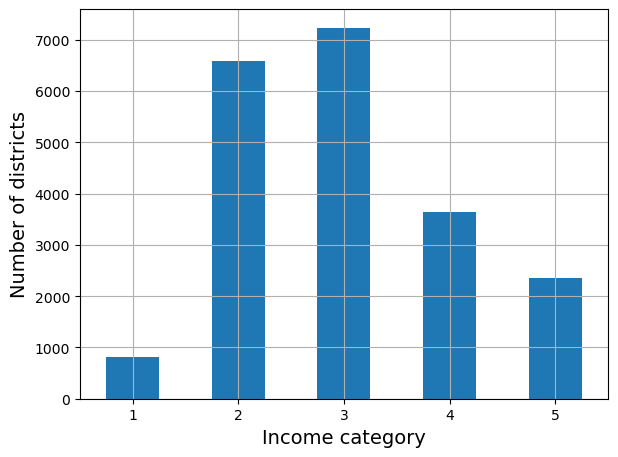

In [22]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")  # extra code
plt.show()

现在你可以根据收入类别进行分层抽样了。ScikitLearn 在 sklearn.model_selection 包中提供了许多 **splitter** 类，它们实现了各种策略，将数据集分割为训练集和测试集。每个 **splitter** 都有一个 **split()** 方法，该方法在相同数据的不同训练/测试分割上返回一个迭代器。

准确地说，split() 方法产生的是训练和测试索引，而不是数据本身。如果您想更好地估计模型的性能，有多个分割是很有用的，我们将在本章后面讨论交叉验证时看到。例如，下面的代码生成同一数据集的10个不同的分层分割：

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

现在，您可以只使用第一个分割：

In [24]:
strat_train_set, strat_test_set = strat_splits[0]

或者，由于分层抽样是相当常见的，有一种更短的方法可以使用 **train_test_split()** 函数来得到单个分割：

In [25]:
strat_train_set, strat_test_set = train_test_split(
    housing, 
    test_size=0.2, 
    stratify=housing["income_cat"], 
    random_state=42)

让我们看看这是否如预期的那样有效。你可以从查看测试集中的收入类别比例开始：

In [26]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

使用类似的代码，您可以度量完整数据集中的收入类别比例。

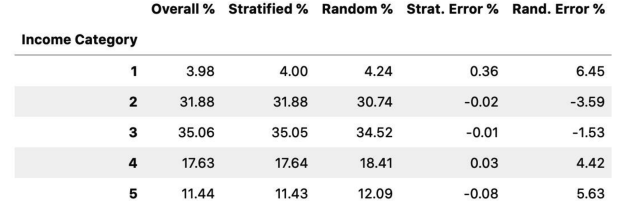

上图比较了总体数据集中、使用分层抽样生成的测试集和使用纯随机抽样生成的测试集中的收入类别比例。正如您所看到的，使用分层抽样生成的测试集的收入类别比例几乎与完整数据集中的收入类别比例相同，而使用纯随机抽样生成的测试集是倾斜的。

In [27]:
# extra code – computes the data for Figure 2–10

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


您不会再使用 **income_cat** 列，所以您最好丢弃它，将数据恢复到原始状态：

In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

我们花了大量时间在测试集生成上是有原因的：这是机器学习项目中经常被忽视但关键的部分。此外，在我们讨论交叉验证时，这些想法将非常有用。现在是时候进入下一个阶段了：探索数据。

## 4. 探索和可视化的数据以获得深入的见解（Explore and Visualize the Data to Gain Insights）

到目前为止，您只快速浏览了一下数据，就可以大致了解您正在操作的数据类型。现在的目标是更深入一些。

首先，确保你已经把测试集放在一边，而你只是在探索训练集。此外，如果训练集非常大，您可能想要抽样进行一个探索集使勘探阶段的操作简单和快速。在这种情况下，训练集非常小，所以您可以直接在整个集合上工作。因为你要尝试对完整的训练集的各种转换，你应该做一个原始的副本，这样你就可以恢复它：

In [29]:
housing = strat_train_set.copy()

### 4.1 可视化地理数据（Visualizing Geographical Data）

由于数据集包括地理信息（纬度和经度），因此最好创建所有地区的散点图来可视化数据：

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


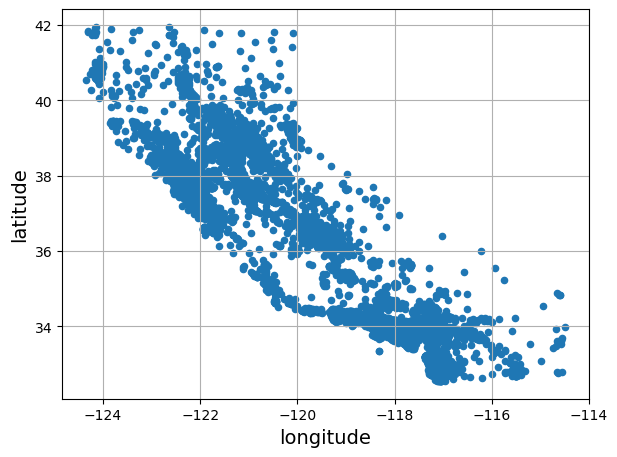

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)

save_fig("bad_visualization_plot")  # extra code

plt.show()

这看起来很像加州，但除此之外，很难看到任何特殊的模式。将alpha选项设置为0.2，可以更容易地可视化数据点密度较高的位置：

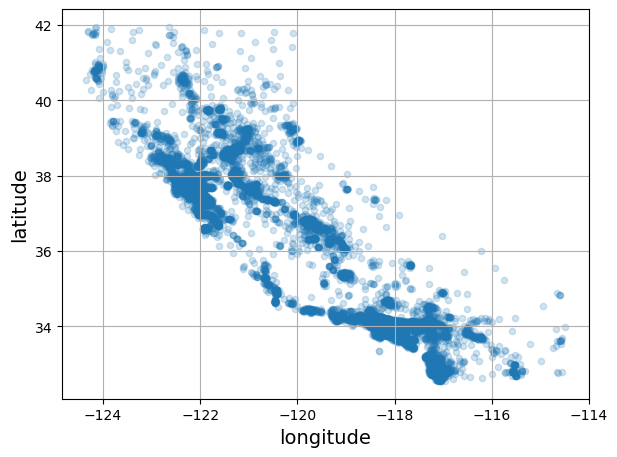

In [31]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)

save_fig("better_visualization_plot")  # extra code

plt.show()

现在好多了：你可以清楚地看到高密度地区，即旧金山湾区、洛杉矶和圣地亚哥周围，以及中央山谷中一长相当高密度的地区（特别是在萨克拉门托和弗雷斯诺附近）。

我们的大脑非常擅长在图片中的模式，但你可能需要使用可视化参数来使模式脱颖而出。

接下来，您将查看房价。每个圆的半径代表该地区的人口（选项s），颜色代表价格（选项c）。在这里，您使用一个名为jet的预定义的颜色地图（选项cmap），其范围从蓝色（低值）到红色（高值）：

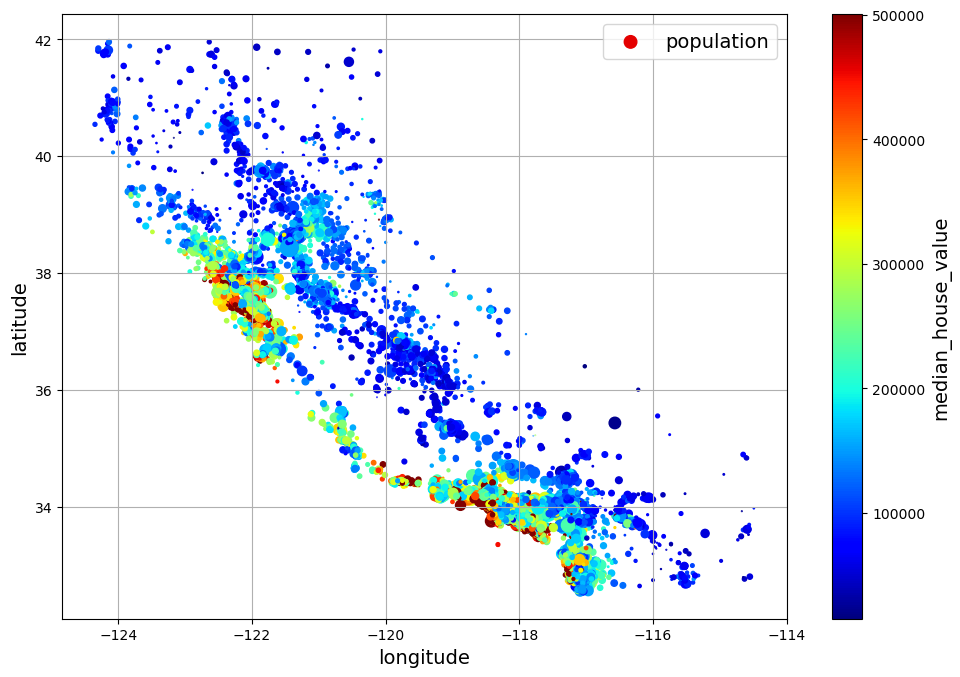

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

save_fig("housing_prices_scatterplot")  # extra code

plt.show()

这张图片告诉你，房价与地理位置（例如，靠近海洋）和人口密度非常相关，你可能已经知道了。聚类算法对于检测主聚类和添加新特征来测量与聚类中心的接近程度是有用的。海洋邻近性属性可能也很有用，尽管在北加州，沿海地区的房价并不太高，所以这不是一个简单的规则。

下一个单元格生成本章的第一个图（本书中没有此代码）。 它只是上图的美化版本，在背景中添加了加利福尼亚的图像，更好的标签名称并且没有网格。

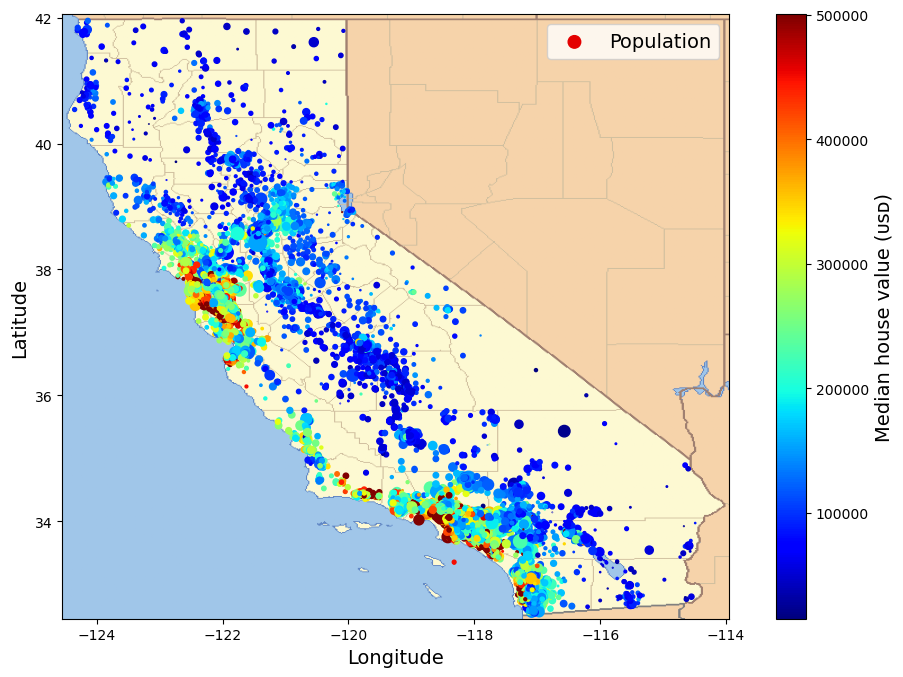

In [33]:
# extra code – this cell generates the first figure in the chapter

# Download the California image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

### 4.2 寻找相关性（Look for Correlations）

由于数据集不是太大，您可以很容易地使用 **corr()** 方法计算每对属性之间的标准相关系数（也称为**皮尔逊系数**）：

In [34]:
corr_matrix = housing.corr()

现在你可以看看每个属性与房屋价值中值的相关性：

In [35]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

相关系数的范围为-1到1。当它接近1时，表示存在很强的正相关；例如，当房价中值上升时，收入中值趋于上升。当系数接近-1时，这意味着存在很强的负相关；你可以看到纬度和房价中值之间的小负相关（即，当你向北走时，价格有轻微的下降趋势）。最后，接近于0的系数意味着没有线性相关。

另一种检查属性之间相关性的方法是使用Pandas **scatter_matrix()** 函数，它将每个数值属性与其他数值属性绘制起来。因为现在有11个数字属性，你会得到112个= 121图，这将不适合一个页面-所以你决定关注一些有希望的属性，这些属性似乎与中位数的住房价值最相关：

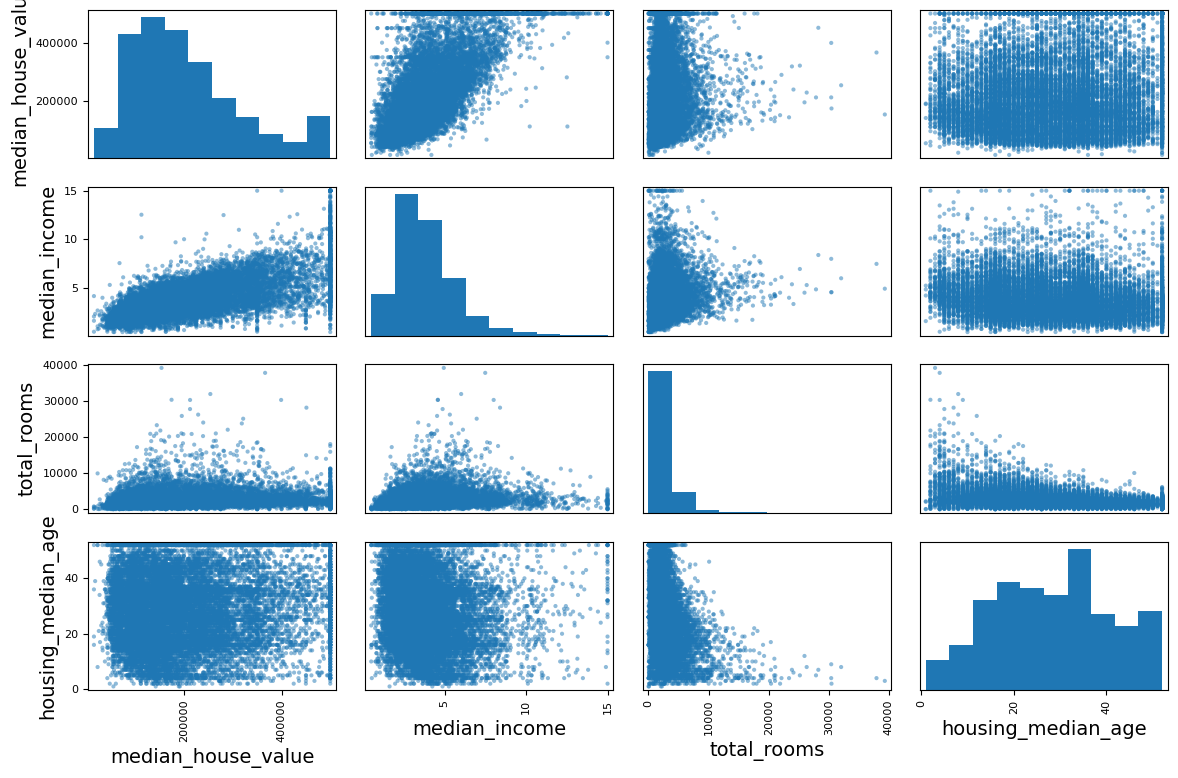

In [36]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

如果Pandas将每个变量与自身绘制，主对角线将充满直线，这不是很有用。因此，Pandas显示每个属性的直方图（有其他选项可用；更多细节请参阅Pandas文档）。

从相关散点图来看，预测房屋价值中值最有希望的属性似乎是收入中值，所以你可以放大他们的散点图：

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


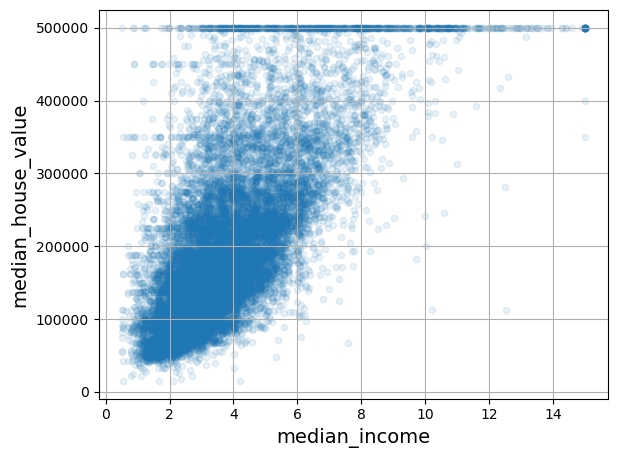

In [37]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)

save_fig("income_vs_house_value_scatterplot")  # extra code

plt.show()

这个情节揭示了一些事情。首先，相关性确实很强；你可以清楚地看到上升的趋势，而且这些点并不是太分散。其次，你之前注意到的价格上限可以清楚地显示为50万美元的水平线。但图片也揭示了其他不太明显的直线：一条水平线大约45万美元，另一条大约35万美元，一条大约28万美元，再低一些。您可能想要尝试删除相应的区域，以防止您的算法学习重现这些数据怪癖。

**注意**：相关系数只测量线性相关性（“当x上升时，y通常会上升/下降”）。它可能会完全错过非线性关系。

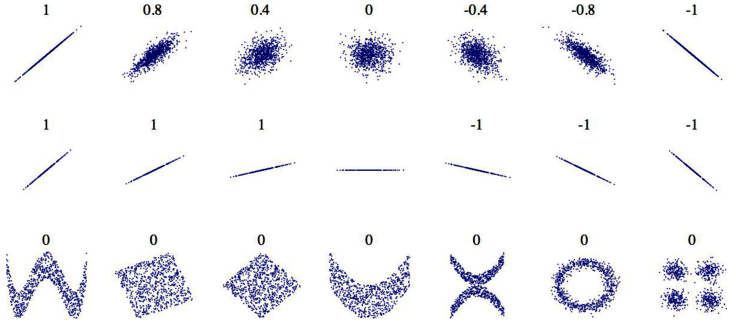

上图显示了各种数据集以及它们的相关系数。请注意，最下面一行的所有图的相关系数都等于0，尽管它们的轴显然不是独立的：这些都是非线性关系的例子。此外，第二行显示了相关系数等于1或-1的例子；请注意，这与斜率无关。例如，你的身高以英寸为单位，与以英尺或纳米为单位的身高的相关系数为1。

### 4.3 使用属性组合的试验（Experiment with Attribute Combinations）

希望前面的部分能给您提供一些探索数据并获得见解的方法。在将数据输入机器学习算法之前，您发现了一些您可能想要清理的数据怪癖，并发现了属性之间有趣的相关性，特别是与目标属性之间的相关性。您还注意到一些属性有一个偏右分布，所以您可能想要对它们进行转换（例如，通过计算它们的对数或平方根）。当然，你的里程会随着每个项目而相差很大，但一般的想法是相似的。

在为机器学习算法准备数据之前，您可能想做的最后一件事是尝试各种属性组合。例如，如果你不知道有多少个家庭，那么一个地区的房间总数就不是很有用了。你真正想要的是每个家庭的房间数量。同样，卧室的总数本身也不是很有用：你可能想要把它和房间的数量进行比较。每个家庭的人口似乎也是一个有趣的属性组合。您可以按如下方式创建这些新属性：

In [38]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [39]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

嘿，还不错！新的卧室比率属性与房价中值的相关性要比房间或卧室的总数大得多。显然，卧室比例较低的房子往往更贵。每个家庭的房间数量也比一个地区的房间总数能提供更多的信息——显然，房子越大，它们就越贵。

这一轮的探索不必绝对彻底；关键是从正确的立足点开始，并迅速获得洞察力，这将帮助你得到第一个相当好的原型。但这是一个迭代的过程：一旦您启动并运行了一个原型，您就可以分析它的输出，以获得更多的见解，并回到这个探索步骤。

## 5. 为机器学习算法准备数据（Prepare the Data for Machine Learning Algorithms）

是时候为你的机器学习算法准备数据了。您应该为此目的编写函数，因为有几个很好的原因：

1. 这将允许您在任何数据集上轻松地复制这些转换（例如，下次当您获得一个新的数据集时）。
2. 您将逐步构建一个可以在未来的项目中重用的转换函数库。
3. 您可以在实时系统中使用这些函数，然后将新数据输入算法。
4. 这将使您可以轻松地尝试各种转换，并查看哪种转换组合最有效。

但是首先，恢复到一个干净的训练集（通过再次复制strat_train_set）。您还应该将预测器和标签分开，因为您不一定希望对预测器和目标值应用相同的转换（注意 **drop()** 创建数据的副本，不会影响 strat_train_set）：

In [40]:
housing = strat_train_set.drop("median_house_value", axis=1)

housing_labels = strat_train_set["median_house_value"].copy()

### 5.1 清洗数据（Clean the Data）

大多数机器学习算法都不能处理缺失的特性，所以你需要处理这些问题。例如，您之前注意到 **total_bedrooms** 属性有一些缺失的值。你有三个选项来解决这个问题：

1. 去掉相应的地区。
2. 去掉整个属性。
3. 将缺失的值设置为某个值（零、平均值、中值等）。这被称为**推断（imputation）**。

你可以轻松地完成这些使用Pandas DataFrame的 **dropna()** ，**drop()** 和 **fillna()** 方法：

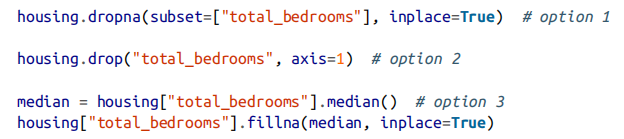

In [41]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [42]:
housing_option1 = housing.copy()

housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1

housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [43]:
housing_option2 = housing.copy()

housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2

housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [44]:
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3

housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


您决定选择选项3，因为它是破坏性最小的，但是不使用前面的代码，而应该使用一个方便的Scikit-Learn类：**SimpleImputer** 。其好处是，它将存储每个特性的中值：这将使缺失的值不仅可以归入训练集，还可以归入验证集、测试集和提供给模型的任何新数据。要使用它，首先您需要创建一个简单的 **SimpleImputer** 实例，指定您要用该属性的中值替换每个属性中的缺失值：

In [45]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

由于中值只能根据数值属性计算，因此需要创建一个仅包含数值属性的数据副本（这将排除文本属性ocean_cleniat）：

In [46]:
housing_num = housing.select_dtypes(include=[np.number])

housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


现在，您可以使用 **fit()** 方法将输入器实例拟合到训练数据中：

In [47]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

**imputer** 只是简单地计算了每个属性的中值，并将结果存储在其 **statistics_** 实例变量中。只有 **total_bedrooms** 属性缺失值，但您不能确定系统运行后新数据中不会有任何缺失值，所以将输入应用于所有数字属性更安全：

In [48]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [49]:
# Check that this is the same as manually computing the median of each attribute:

housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

现在你可以使用这个“已经训练”的 **imputer** ，用学习的中值替换缺失的值来转换训练集：

In [50]:
X = imputer.transform(housing_num)

X

array([[-1.2242e+02,  3.7800e+01,  5.2000e+01, ...,  1.5760e+03,
         1.0340e+03,  2.0987e+00],
       [-1.1838e+02,  3.4140e+01,  4.0000e+01, ...,  6.6600e+02,
         3.5700e+02,  6.0876e+00],
       [-1.2198e+02,  3.8360e+01,  3.3000e+01, ...,  5.6200e+02,
         2.0300e+02,  2.4330e+00],
       ...,
       [-1.1706e+02,  3.2590e+01,  1.3000e+01, ...,  2.8140e+03,
         7.6000e+02,  4.0616e+00],
       [-1.1840e+02,  3.4060e+01,  3.7000e+01, ...,  1.7250e+03,
         8.3800e+02,  4.1455e+00],
       [-1.2241e+02,  3.7660e+01,  4.4000e+01, ...,  6.8200e+02,
         2.1200e+02,  3.2833e+00]])

In [51]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

缺失的值也可以用平均值（ **strategy="mean"** ）代替，或者用最频繁的值（ **strategy="most_frequent"** ）代替，或者用常数值（ **strategy="constant", fill_value=…** ）代替。后两种策略都支持非数值数据。

在 **sklearn.impute** 包中也有更强大的 **imputer**（两者仅适用于数字特征）：

1. **KNNImputer** 将每个缺失的值替换为该特征的k近邻值的平均值。这个距离是基于所有可用的特性来确定的。
2. **IterativeImputer** 为每个特征训练一个回归模型，基于所有其他可用特征预测缺失值。然后，它对更新后的数据再次训练模型，并重复这个过程几次，在每次迭代中改进模型和替换值。



Scikit-Learn transformers 输出 NumPy 数组（或有时 SciPy 稀疏矩阵），即使他们被输入 Pandas DataFrames。因此，**imputer.transform(housing_num)** 的输出是一个 NumPy 数组：X既没有列名，也没有索引。幸运的是，将X包装在一个DataFrame中，并从housing_num中恢复列名和索引并不难：

In [52]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


In [53]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [54]:
imputer.strategy

'median'

In [55]:
# Now let's drop some outliers（异常值）:

from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [56]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

In [57]:
# 删除异常值

housing = housing.iloc[outlier_pred == 1]
housing_labels = housing_labels.iloc[outlier_pred == 1]

### 5.2 处理文本和分类属性（Handling Text and Categorical Attributes）

到目前为止，我们只处理了数字属性，但您的数据也可能包含文本属性。在这个数据集中，只有一个：**ocean_proximity** 属性。让我们来看一下前几个实例的值：

In [58]:
housing_cat = housing[["ocean_proximity"]]

housing_cat.head(8)

,ocean_proximity
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN


它不是任意的文本：可能的值数量有限，每个值代表一个类别。所以这个属性是一个分类属性。大多数机器学习算法更喜欢使用数字，所以让我们将这些类别从文本转换为数字。为此，我们可以使用Scikit-Learn的普通编码器类：

In [59]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:8]

array([[0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.]])

您可以使用 **categories_** 实例变量获取类别列表。它是一个包含每个类别属性的一维类别数组的列表（在本例中，是一个包含单个数组的列表，因为只有一个类别属性）：

In [60]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

这种表示的一个问题是，ML算法将假定两个临近的值比两个遥远的值更相似。在某些情况下，这可能是好的（例如，对于“坏”、“平均”、“好”和“优秀”），但 **ocean_proximity** 列并不合适（例如，类别0和4显然比类别0和1更相似）。为了解决这个问题，一个常见的解决方案是为每个类别创建一个二进制属性：当类别是“<1H OCEAN”时，一个属性等于1（否则为0），当类别是“INLAND”时，另一个属性等于1（否则等于0），以此类推。这称为**独热编码（one-hot encoding）**，因为只有一个属性等于1（hot），而其他属性等于0（cold）。这些新的属性有时被称为**哑属性（dummy attributes）**。Scikit-Learn提供了一个 **OneHotEncoder** 类，将分类值转换为独热向量：

In [61]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot

<14448x5 sparse matrix of type '<class 'numpy.float64'>'
	with 14448 stored elements in Compressed Sparse Row format>

默认情况下，OneHotEncoder 的输出是一个 SciPy 稀疏矩阵，而不是一个 NumPy 数组。

稀疏矩阵是一个非常有效的矩阵的主要包含零的表示。实际上，它在内部只存储非零值及其位置。当一个类别属性有数百或数千个类别时，一个热编码它会产生一个非常大的矩阵，充满0，除了每行一个1。在这种情况下，稀疏矩阵正是您所需要的：它将节省大量内存并加快计算速度。你可以像使用一个普通的二维数组使用一个稀疏矩阵，但如果你想转换成一个（密集的）NumPy数组，只需调用 **toarray()** 方法：

In [62]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

或者，您可以在创建 **OneHotEncoder** 时设置 **sparse=False** ，在这种情况下，**transform()** 方法将直接返回一个规则的（密集的）NumPy数组。

In [63]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

与 **OrdinalEncoder** 一样，您可以使用编码器的 **categories_** 实例变量获得类别列表：

In [64]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Pandas 有一个名为 **get_dummies()** 的函数，它还将每个分类特征转换为独热表示，每个类别有一个二进制特征：

In [65]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})

pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


它看起来很漂亮和简单，所以为什么不用它来代替 **OneHotEncoder** 呢？嗯，独热编码器的优点是它可以记住它被训练过的类别。这是非常重要的，因为一旦你的模型投入生产，它应该得到与训练期间完全相同的特性：不再多，不再少。看看我们的训练好的 **cat_encoder** 输出，当我们使它转换相同的 **df_test**（使用 **transform()** ，而不是 **fit_transform()** ）：

In [66]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

看到什么区别了吗？**get_dummies()** 只看到两个类别，所以它输出两列，而 **OneHotEncoder** 以正确的顺序每个学习过的类别输出一列。此外，如果你给 **get_dummies()** 提供一个包含一个未知类别的 DataFrame（例如，“<2H OCEAN”），它将很高兴地为它生成一个列：

In [67]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,1,0
1,0,1


但 **OneHotEncoder** 更聪明：它将检测未知类别并引发异常。如果您愿意，您可以将 **handle_unknown** 超参数设置为“**ignore**”，在这种情况下，它将只用零表示未知的类别：

In [68]:
cat_encoder.handle_unknown = "ignore"

cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

**注意**：如果一个分类属性有大量可能的类别（例如，国家代码、职业、物种），那么独热编码将导致大量的输入特性。这可能会降低训练速度和表现。如果发生这种情况，您可能希望用与类别相关的有用数字数据来替换类别输入：例如，您可以用到海洋的距离替换 **ocean_proximity** 特征（类似地，国家代码可以用国家的人口和人均GDP替换）。或者，您可以使用GitHub上的 **category_encoders** 包提供的编码器之一。或者，在处理神经网络时，你可以用一个可学习的、低维的 **嵌入向量（embedding）** 来替换每个类别。这是一个 **表示学习（representation learning）** 的例子。

当您使用 DataFrame 适配任何 Scikit-Learn estimator 时，estimator 将列名存储在 **feature_names_in_** 属性中。然后，Scikit-Learn 确保之后（例如，transform() 或 predict()）输入到此 estimator 的任何 DataFrame具有相同的列名。Transformers 还提供了一个 **get_feature_names_out()** 方法，您可以使用它来围绕 transformer 的输出构建一个 DataFrame ：

In [69]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [70]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [71]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


### 5.3 特征缩放和转换（Feature Scaling and Transformation）

您需要应用于数据的最重要的转换之一是**特性缩放（feature scaling）**。除了少数例外，当输入的数值属性具有非常不同的尺度时，机器学习算法表现得不是很好。住房数据的情况是这样的：房间总数在6到39320之间，而收入中位数仅在0到15之间。如果没有任何比例，大多数模型都会倾向于忽略收入中位数，而更多地关注房间的数量。

有两种常见的方法可以使所有属性具有相同的缩放：**最小-最大缩放（min-max scaling）** 和 **标准化（standardization）** 。

**所有的估计器都一样，只将缩放器拟合到训练数据中是很重要的**：除了训练集之外，不要对任何东西使用 **fit()** 或 **fit_transform()** 。一旦您有了一个训练过的缩放器，您就可以使用它来 **transform()** 的任何其他集，包括验证集、测试集和新数据。请注意，虽然训练集的值将始终缩放到指定的范围，但如果新数据包含异常值，这些值可能最终缩放到范围之外。如果要避免这种情况，只需将 **clip** 超参数设置为 **True**。

**最小-最大缩放（min-max scaling）**（许多人称之为**标准化（normalization）**）是最简单的：对于每个属性，值被移动和重新缩放，以便它们最终的范围从0到1。这是通过减去最小值并除以最小值和最大值之间的差来实现的。Scikit-Learn为此提供了一个称为 **MinMaxScaler** 的转换器。它有一个 **feature_range** 超参数，如果你不想要0-1，你可以改变范围（例如，神经网络在零均值输入下工作得最好，所以-1到1的范围更可取）。它很容易使用：

In [72]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

housing_num_min_max_scaled

array([[-0.60851927,  0.11702128,  1.        , ..., -0.80701754,
        -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, ..., -0.91866029,
        -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, ..., -0.93141946,
        -0.92458466, -0.73336919],
       ...,
       [ 0.47870183, -0.99148936, -0.52941176, ..., -0.65513434,
        -0.71663244, -0.50873781],
       [ 0.20689655, -0.6787234 ,  0.41176471, ..., -0.78873758,
        -0.68751167, -0.49716556],
       [-0.60649087,  0.08723404,  0.68627451, ..., -0.91669734,
        -0.92122457, -0.61608805]])

**标准化（Standardization）** 是不同的：首先它减去平均值（所以标准化值的平均值为零），然后它将结果除以标准差（所以标准化值的标准差等于1）。与最小-最大比例不同，标准化化并不将值限制在特定的范围内。然而，标准化受到异常值的影响要小得多。例如，假设一个地区的收入中位数等于100（错误的），而不是通常的0-15。最小-最大缩放到0-1范围将把这个异常值映射到1，并将所有其他值压缩到0-0.15，而标准化不会受到太大影响。Scikit-Learn提供了一个称为 **StandardScaler** 的转换器，用于标准化：

In [73]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

housing_num_std_scaled = std_scaler.fit_transform(housing_num)

housing_num_std_scaled

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]])

如果您想缩放稀疏矩阵而不首先将其转换为稠密矩阵，您可以使用 **StandardScaler** ，其 **with_mean** 超参数设置为 **False**：它只将数据除以标准差，而不减去平均值（因为这将打破稀疏性）。

当一个特征的分布有一个 **重尾（heavy tail）** 时（即，当远离平均值的值不是指数罕见时），**最小-最大缩放（min-max scaling）** 和 **标准化（standardization）** 都会将大多数值压缩到一个小的范围内。

机器学习模型通常根本不喜欢这个，你将在第4章中看到。**因此，在缩放该特征之前，您应该首先将它转换以缩小重尾，如果可能的话，使分布大致对称**。例如，对于右边有重尾的积极特征，一种常见的方法是用其平方根替换特征（或者将特征提高到0到1之间的幂）。如果这个特征有一个又长又重的尾巴，比如 **幂律分布（power law distribution）** ，那么用对数替换这个特征可能会有所帮助。例如，population 特征大致遵循幂律：有10000居民的地区比1000居民的地区少10倍，而指数罕见的频率。

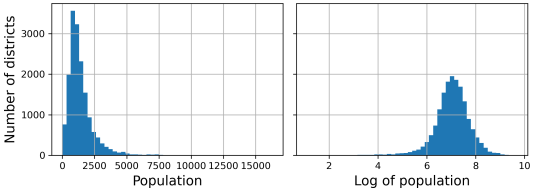

上图显示了当你计算它的对数时，它看起来有多好：它非常接近高斯分布(即钟形）。

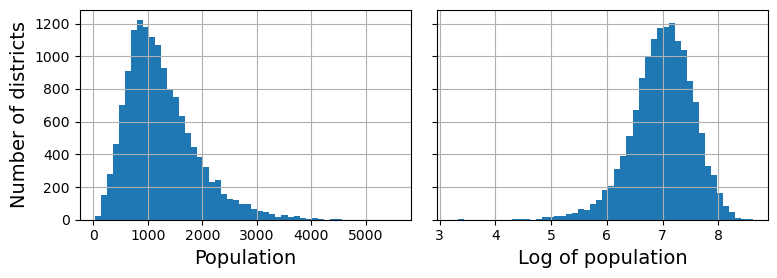

In [74]:
# extra code – this cell generates Figure

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

处理重尾特性的另一种方法是对特征进行 **分组（bucketizing）** 。这意味着将它的分布分割成大致大小相等的桶，并用它所属的桶的索引替换每个特征值，就像我们在创建 income_cat 特征时所做的那样（尽管我们只将它用于分层抽样）。例如，您可以用其百分位数替换每个值。使用相同大小的桶进行分段会产生几乎均匀分布的特性，因此不需要进一步缩放，或者您可以只除以桶的数量，强制值到0-1范围。

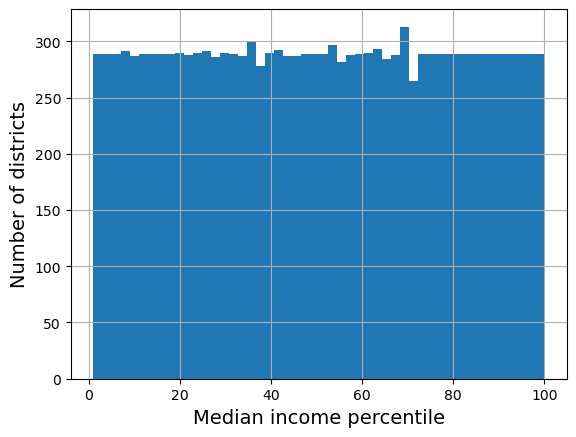

In [75]:
# extra code – just shows that we get a uniform distribution
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]

flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))

flattened_median_income.hist(bins=50)

plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).

当一个特征具有 **多模态分布（multimodal distribution）**（即，有两个或更多清晰的峰，称为 **模式（modes）**），如 housing_median_age 特征，对其进行分组也是有效的，但这次将桶 ID 作为类别，而不是数字值。这意味着必须对桶索引进行编码，例如使用 OneHotEncoder（所以您通常不想使用太多的桶）。这种方法将允许回归模型更容易地学习该特征值的不同范围的不同规则。例如，也许大约35年前建造的房子有一种特殊的风格，但已经过时了，因此它们比它们的年龄所暗示的要便宜。

另一种改变多模态分布的方法是为每种模式（至少是主要模式）添加一个特征，表示住房年龄中位数和该特定模式之间的相似性。相似度度量通常使用一个 **径向基函数（radial basis function，RBF）** 来计算——任何只取决于输入值和一个固定点之间的距离的函数。最常用的RBF是 **高斯RBF（Gaussian RBF）** ，其输出值随着输入值远离不动点而呈指数衰减。例如，住宅年龄 $x$ 和35之间的高斯RBF相似性由方程 $e^{-\gamma(x-35)^2}$ 给出。超参数 **γ（gamma）** 决定了相似性度量度量在 $x$ 远离35时衰减的速度。使用Scikit-Learn的 **rbf_kernel()** 函数，您可以创建一个新的高斯RBF特征，测量住房中位数年龄和35岁之间的相似性：

In [76]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

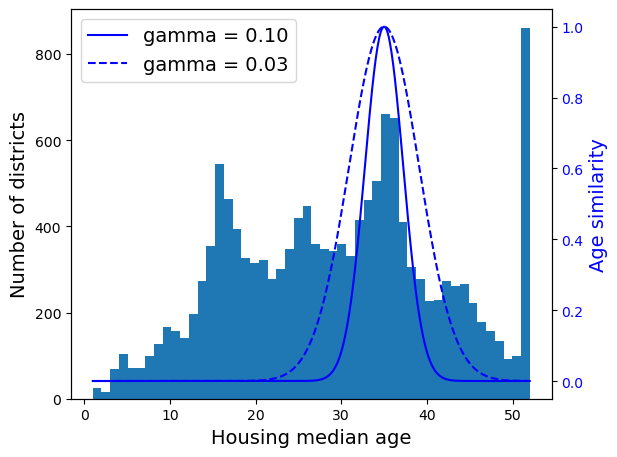

In [77]:
# extra code – this cell generates Figure

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()

上图显示了这一新特征作为住房中位数年龄的函数（实线）。它还显示了如果您使用一个较小的伽马值，该特性会是什么样子。如图所示，新的年龄相似性特征在35岁时达到峰值，就在住房中位数年龄分布的峰值附近：如果这个特定的年龄组与较低的价格有很好的相关性，那么这个新特征很有可能会有所帮助。

到目前为止，我们只查看了输入特性，但目标值也可能需要进行转换。例如，如果目标分布有一个重尾，您可以选择用其对数替换目标。但如果你这样做了，回归模型现在将预测房屋中值的对数，而不是房屋中值本身。如果你想要预测的房屋中值，你需要计算模型预测的指数。

幸运的是，大多数Scikit-Learn的转换器都有一个 **inverse_transform()** 方法，这使得计算它们的逆变换很容易。例如，下面的代码示例显示了如何使用 StandardScaler 缩放标签，然后训练一个简单的线性回归模型产生缩放后的标签并使用它来预测一些新数据，我们使用经过训练的缩放器的 **inverse_transform()** 方法转换回原始规模。请注意，我们将标签从 Pandas Series 转换为 DataFrame ，因为 StandardScaler 期望二维输入。此外，在这个例子中，为了简单起见，我们只用一个单一的原始输入特征（收入中位数）来训练模型：

In [78]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

predictions

array([[307649.58358784],
       [143451.50154782],
       [135759.63057829],
       [192702.83891231],
       [184498.77560018]])

这工作得很好，但一个更简单的选择是使用 **TransformedTargetRegressor** 。我们只需要构造它，给它回归模型和标签转换器，然后使用原始的未缩放的标签将它拟合到训练集上。它将自动使用转换器来缩放标签，并在生成的缩放标签上训练回归模型，就像我们之前所做的那样。然后，当我们想要进行预测时，它将调用回归模型的 **predict()** 方法，并使用缩放器的 **inverse_transform()** 方法来产生预测：

In [79]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())

model.fit(housing[["median_income"]], housing_labels)

predictions = model.predict(some_new_data)

predictions

array([307649.58358784, 143451.50154782, 135759.63057829, 192702.83891231,
       184498.77560018])

### 5.4 自定义转换器（Custom Transformers）

尽管Scikit-Learn提供了许多有用的转换器，但您将需要编写自己的任务，如自定义转换、清理操作或组合特定的属性。

对于不需要任何训练的转换，您可以编写一个函数，以一个NumPy数组作为输入并输出转换后的数组。例如，如前一节所讨论的，用对数替换重尾分布的特征通常是一个不错的主意（假设特征是正的，并且尾部在右边）。让我们创建一个日志转换器，并将其应用于 population 特征：

In [80]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)

log_pop = log_transformer.transform(housing[["population"]])

**inversefunc** 参数是可选的。它允许您指定一个逆转换函数，例如，如果您计划在 **TransformedTargetRegressor** 或中使用转换器。

转换函数可以替换超参数作为附加参数。例如，这里是和之前一样创建一个转换器，计算相同的高斯RBF相似性度量：

In [81]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))

age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

age_simil_35

array([[8.20849986e-02],
       [6.70320046e-01],
       [8.48904403e-15],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

请注意，RBF kernel没有逆函数，因为距离一个固定点的给定距离上总是有两个值（在距离0时除外）。还要注意的是，rbf_kernel() 并没有单独处理这些特性。如果你给它传递一个具有两个特征的数组，它将度量二维距离（欧几里得）来度量相似性。例如，以下是如何添加一个特征，来衡量每个地区和旧金山之间的地理相似性：

In [82]:
sf_coords = 37.7749, -122.41

sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))

sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

sf_simil

array([[0.05258419],
       [0.94864161],
       [0.01192662],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

自定义转换器对于组合特征也很有用。例如，这里有一个 **FunctionTransformer** ，它计算输入特征0和1之间的比率：

In [83]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])

ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

**FunctionTransformer** 非常方便，但是如果你希望你的变压器是可训练的，在 **fit()** 方法中学习一些参数，然后在 **transform()** 方法中使用它们呢？

为此，您需要编写一个自定义类。Scikit-Learn依赖于 **鸭子类型（duck typing）** ，所以这个类不需要从任何特定的基类继承。它所需要的仅仅是三种方法：**fit()** （它必须返回自身）、**transform()** 和 **fit_transform()** 。

您可以通过简单地添加 **TransformerMixin** 作为基类来获得 **fit_transform()** ：默认的实现将只调用 **fit()** ，然后 **transform()** 。如果您将 **BaseEstimator** 作为基类添加（并避免在构造函数中使用 \*args 和 \*\*kwargs ），您还将得到两个额外的方法：**get_params()** 和 **set_params()** 。这些对于自动超参数调优将很有用。

例如，这里有一个自定义转换器，它的作用非常类似于 **StandardScaler** ：

In [84]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

**以下有几件事需要注意**：

1. **sklearn.utils.validation** 包包含了几个我们可以用于验证输入的函数。为简单起见，我们将在本书的其余部分中跳过这样的测试，但是生产代码应该有它们。
2. Scikit-Learn pipeline 需要 **fit()** 方法有两个参数 $X$ 和 $y$ ，这就是为什么我们需要 $y=None$ 参数，即使我们不使用 $y$ 。
3. 所有的 Scikit-Learn estimators 在 **fit()** 方法中设置了 **n_features_in_** ，它们确保数据传递给 **transform()** 或 **predict()** 的数据具有相同数量的特征。
4. **fit()** 方法必须返回自身 self。
5. 这个实现不是100%完整的：当所有估计器传递 DataFrame 时，都应该在 **fit()** 方法中设置 **feature_names_in_** 。此外，所有的转换器都应该提供一个 **get_feature_names_out()** 方法，以及当它们的转换可以反转时提供一个 **inverse_transform()** 方法。

自定义转换器可以（而且经常可以）在其实现中使用其他 estimators 。例如，下面的代码演示了自定义转换器，它在 **fit()** 方法中使用 **KMeans** 集群来识别训练数据中的主要集群，然后在 **transform()** 方法中使用 **rbf_kernel()** 来衡量每个样本与每个集群中心的相似程度：

In [85]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

您可以传递一个实例给 **sklearn.utils.estimator_checks** 包中的 **check_estimator()** ，来检查自定义估计器是否遵从 Scikit-Learn 的 API 。

正如您将在第9章中看到的，k-means 是一种在数据中定位集群的聚类算法。它搜索的数量由 **n_clusters** 超参数控制。训练结束后，集群中心可以通过 **cluster_centers_** 属性获得。KMeans 的 **fit()** 方法支持一个可选的参数 **sample_weight** ，它允许用户指定样本的相对权值。k-means 是一种随机算法，这意味着它依赖于随机性来定位集群，所以如果你想要可重复的结果，你就必须设置 **random_state** 参数。正如您所看到的，尽管任务很复杂，但代码却相当简单。现在让我们使用这个自定义转换器：

In [86]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

这段代码创建了一个 **ClusterSimilarity** 转换器，将集群的数量设置为10个。然后对训练集中每个区域的经纬度调用 **fit_transform()** ，将每个区域的房价中值进行加权。该转换器使用 k-means 来定位集群，然后测量每个区域和所有10个集群中心之间的高斯RBF相似度。结果是一个矩阵，每个地区有一行，每个集群有一列。让我们来看看前三行，四舍五入到小数点的后两位：

In [87]:
similarities[:3].round(2)

array([[0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.  , 0.68, 0.11, 0.  ],
       [0.7 , 0.  , 0.  , 0.  , 0.29, 0.11, 0.45, 0.  , 0.  , 0.29],
       [0.  , 0.2 , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.59, 0.  , 0.  ]])

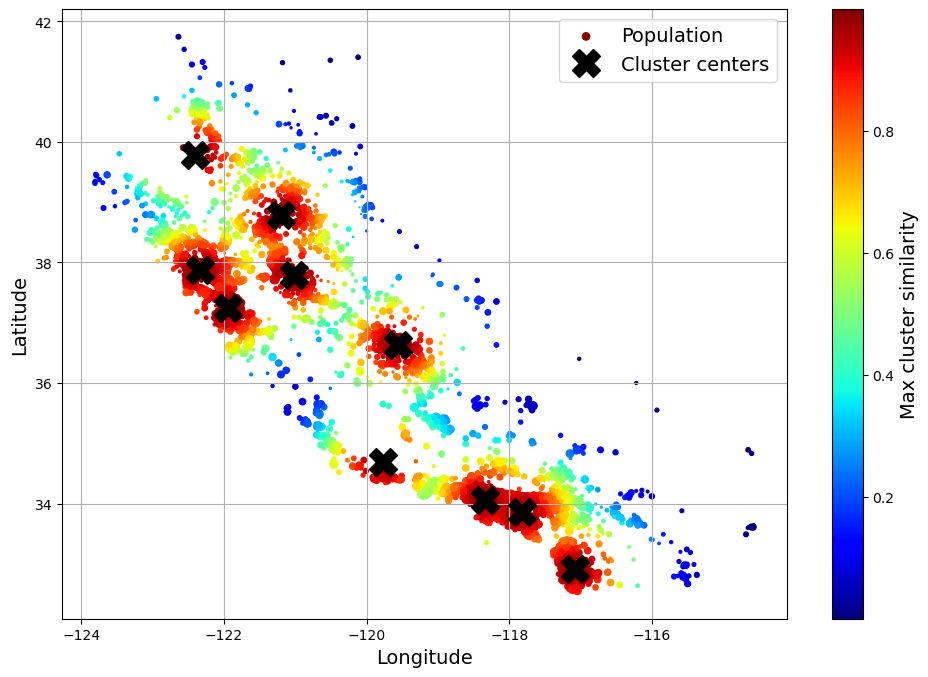

In [88]:
# extra code – this cell generates Figure

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})

housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))

plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")

plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

### 5.5 转换 pipeline（Transformation Pipelines）

如您所见，有许多数据转换步骤需要以正确的顺序执行。幸运的是，Scikit-Learn提供了 **Pipeline** 类来帮助处理这样的转换序列。这里是一个数值属性的小 pipeline，它将首先补充缺失值，然后缩放输入特征：

In [89]:
from sklearn.pipeline import Pipeline

#sklearn.set_config(display="diagram")

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

**Pipeline** 构造函数接受一个定义步骤序列的 **name/estimator** 对（二元组）的列表。这些名称可以是你喜欢的任何东西，只要它们是唯一的，并且不包含双下划线（\_\_）。稍后，当我们讨论超参数调优时，它们将会很有用。估计器必须都是转换器（即它们必须有一个 **fit_transform()** 方法），除了最后一个，它可以是任何东西：转换器、预测器或任何其他类型的估计器。

在Jupyter notebook中，如果你 **import sklearn** 并运行 **sklearn.set_config(display="diagram")** ，所有 Scikit-Learn 估计器将呈现为交互式图。这对于可视化 pipeline 特别有用。若要可视化 **num_pipeline** ，请运行一个以 **num_pipeline** 为最后一行的单元格。单击一个估计器将会显示更多的细节。


In [90]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

如果您不想为转换器命名，您可以使用 **make_pipeline()** 函数；它将转换器作为位置参数，并使用转换器类的名称创建一个 **Pipeline** ，小写且没有下划线（例如，"simpleimputer"），如果多个转换器具有相同的名称，则在其名称后面附加一个索引（例如，“foo1”、“foo2”等）：

In [91]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

当您调用管道的 **fit()** 方法时，它在所有转换器上依次调用 **fit_transform()** ，将每个调用的输出作为参数传递给下一个调用，直到它到达最终的估计器，为此它只用调用 **fit()** 方法。

该 pipeline 公开了与最终 estimator 相同的方法。在这个例子中，最后一个估计器是一个 **StandardScaler** ，它是一个转换器，所以管道也就像一个转换器。如果调用管道的 **transform()** 方法，它将按顺序将所有转换应用到数据上。如果最后一个估计器是一个预测器而不是一个转换器，那么管道将会有一个 **predict()** 方法，而不是一个 **transform()** 方法。调用它将按顺序将所有转换应用到数据中，并将结果传递给预测器的 **predict()** 方法。

让我们调用管道的 **fit_transform()** 方法，看看输出的前两行，四舍五入到小数点后两行：

In [92]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)

housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

正如您前面看到的，如果您想恢复一个漂亮的 DataFrame ，您可以使用 pipeline 的 **get_feature_names_out()** 方法：

In [93]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396


pipeline 支持索引；例如，**pipeline\[1\]** 返回管道中的第二个估计器，而 **pipeline\[:-1\]** 返回一个 **Pipeline** 对象，其中包含除最后一个估计器以外的所有估计器。您还可以通过 **steps** 属性（名称/估计器对组列表）或通过 **named_steps** 字典属性（将名称映射到估计器）访问估计器。例如，**num_pipeline\["simpleimputer"\]** 返回名为“**simpleimputer**”的估计器。

In [94]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [95]:
num_pipeline[1]

StandardScaler()

In [96]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [97]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [98]:
num_pipeline["simpleimputer"]

SimpleImputer(strategy='median')

In [99]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

到目前为止，我们已经分别处理了分类列和数字列。有一个能够处理所有列的转换器，对每个列应用适当的转换将会更方便。为此，您可以使用 **ColumnTransformer** 。例如，下面的 **ColumnTransformer** 将把 **num_pipeline**（我们刚刚定义的那个）应用于数字属性，**cat_pipeline** 应用于的分类属性：

In [100]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['ocean_proximity'])])

首先，我们导入 **ColumnTransformer** 类，然后我们定义数字列名和分类列名的列表，并为分类属性构造一个简单的 pipeline 。最后，我们构造了一个 **ColumnTransformer** 。它的构造函数需要一个三元组（3个元组）列表，每个单元包含一个名称（必须是唯一的，不包含双下划线）、一个转换器，以及应该应用转换器的列的名称（或索引）列表。

如果您希望删除列，您可以指定字符串“**drop**”而不是使用转换器，或者如果您希望列保持不变，您可以指定“**passthrough**”。 默认情况下，剩余的列（即未列出的列）将被删除，但如果您希望以不同方式处理这些列，则可以将 **remainder** 超参数设置为任何转换器（或“**passthrough**”）。

由于列出所有列名并不是很方便，因此 Scikit-Learn 提供了一个 **make_column_selector()** 函数，它返回一个选择器函数，您可以使用该选择器函数自动选择给定类型的所有特征，如数字的或分类的。您可以将此选择器函数传递给 **ColumnTransformer** ，而不是列名或索引。此外，如果您不关心命名转换器，您可以使用 **make_column_transformer()** ，它为您选择名称，就像 **make_pipeline()** 所做的一样。例如，下面的代码创建了与以前相同的 **ColumnTransformer** ，除了转换器被自动命名为“pipeline-1”和“pipeline-2”，而不是“num”和“cat”：

In [101]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023BBB533A60>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023BBC7CF520>)])

现在我们准备将这个 **ColumnTransformer** 应用于住房数据：

In [102]:
housing_prepared = preprocessing.fit_transform(housing)

housing_prepared

array([[ 0.59552705, -0.69280115,  0.87590394, ...,  0.        ,
         0.        ,  0.        ],
       [-1.27303205,  1.36192447,  0.29234496, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.25471318, -0.88269285, -1.04150415, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.28066539, -1.44749894, -1.37496642, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58514617, -0.73175329,  0.62580723, ...,  0.        ,
         0.        ,  0.        ],
       [-1.49622105,  1.0210932 ,  1.20936621, ...,  0.        ,
         0.        ,  1.        ]])

该预处理 pipeline ，它接收整个训练数据集，并将每个转换器应用到适当的列，然后水平连接转换形成的列（转换器永远不能改变行数）。这再次返回一个NumPy数组，但是您可以使用 **preprocessing.get_feature_names_out()** 获得列名，并像我们之前所做的那样将数据包装在一个漂亮的 DataFrame 中。

In [103]:
# extra code – shows that we can get a DataFrame out if we want
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
14973,0.595527,-0.692801,0.875904,-0.257539,-0.479342,-0.911423,-0.367756,1.383990,1.0,0.0,0.0,0.0,0.0
3785,-1.273032,1.361924,0.292345,-1.043780,-1.077558,-1.073350,-1.092179,-0.804668,0.0,1.0,0.0,0.0,0.0


**OneHotEncoder** 返回一个稀疏矩阵，而 **num_pipeline** 返回一个密集矩阵。当存在稀疏和密集矩阵的混合时，**ColumnTransformer** 估计最终矩阵的密度（即非零单元的比率），如果密度低于给定的阈值（默认情况下 **sparse_threshold=0.3** ），则返回稀疏矩阵。在本例中，它返回一个密集的矩阵。

你的项目进行得很顺利，你几乎已经准备好训练一些模型了！您现在希望创建一个单一的管道，它将执行您迄今为止所尝试过的所有转换。让我们回顾一下管道将做什么以及为什么这样做：

1. 数值特征中所缺失的值将通过用中值替换它们来计算，因为大多数ML算法并不期望缺失值。在分类特征中，缺失的值将被最常见的类别所取代。
2. 分类特征将是独热编码，因为大多数ML算法只接受数字输入。
3. 计算并添加一些比例特征：卧室比例、每个房子的房间和每个房子的人。希望这些数据能更好地与房价中值相关联，从而帮助ML模型。
4. 此外，还将添加一些集群相似性特性。这些数据可能比经纬度对模型更有用。
5. 具有长尾的特征将被它们的对数所取代，因为大多数模型更喜欢具有大致均匀或高斯分布的特征。
6. 所有的数值特征都将标准化，因为大多数ML算法喜欢当所有特征具有大致相同的尺度。

构建要完成所有这些工作的管道的代码现在对您来说看起来应该很熟悉了：

In [104]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x0000023BB9C955E0>,
                                                                      func=<function column_r...
                                 ['total_bedrooms', 'total_rooms', 'population',
                                  'households', 'median_income']),
                                ('geo', ClusterSimilarity(random_state=42),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023BB993BBB0>)])

如果你运行这个 **ColumnTransformer** ，它会执行所有的转换并输出一个具有24个特征的NumPy数组：

In [105]:
housing_prepared = preprocessing.fit_transform(housing)

housing_prepared.shape

(14448, 24)

In [106]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

## 6. 选择并训练一个模型（Select and Train a Model）

最后！你确定了问题，你得到了数据并探索了它，你采样了一个训练集和一个测试集，你编写了一个预处理管道来自动清理并为机器学习算法准备数据。您现在已经准备好选择和训练一个机器学习模型了。

### 6.1 在训练集上的训练与评估（Train and Evaluate on the Training Set）

好消息是，多亏了前面所有这些步骤，事情现在将变得容易了！你决定训练一个非常基本的线性回归模型来开始：

In [107]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())

lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023BB993BBB0>)])),
                ('linearregression', LinearRegression())])

你现在有了一个可工作的线性回归模型。你可以在训练集中尝试一下，看看前五个预测，并将它们与标签进行比较：

In [108]:
housing_predictions = lin_reg.predict(housing)

housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([379400., 118900.,  96400., 344000., 196300.])

In [109]:
housing_labels.iloc[:5].values

array([483800., 101700.,  96100., 361800.,  92600.])

好吧，它奏效了，但并非总是如此：第一个预测还远远遥远（超过20万美元！），而其他的预测则更好：两个下跌了约25%，两个下跌了不到10%。请记住，您选择使用RMSE作为您的性能度量，所以您希望使用Scikit-Learn的 **mean_squared_error()** 函数来在整个训练集上度量这个回归模型的RMSE，其中 **squared** 参数设置为 **False** ：

In [110]:
# extra code – computes the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1

print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-21.6%, 16.9%, 0.3%, -4.9%, 112.0%


In [111]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels,
                              housing_predictions,
                              squared=False)

lin_rmse

66012.83832242119

这总比什么都没有好，但显然不是一个很好的分数：大多数地区的房价中值在12万美元到26.5万美元之间，所以一个典型的68,628美元的预测误差真的不是很令人满意。这是一个模型欠拟合训练数据的例子。当这种情况发生时，这可能意味着这些特性没有提供足够的信息来做出良好的预测，或者该模型不够强大。正如我们在前一章中所看到的，修复欠拟合的主要方法是选择一个更强大的模型，给训练算法提供更好的特征，或减少对模型的约束。这个模型没有被正则化，这就排除了最后一个选项。您可以尝试添加更多的特性，但首先您想尝试更复杂的模型，看看它们如何。

您决定尝试 **DecisionTreeRegressor** ，因为这是一个相当强大的模型，能够在数据中找到复杂的非线性关系（在第6章更详细）：

In [112]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))

tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023BB993BBB0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

现在模型已被训练，则在训练集上对其进行评估：

In [113]:
housing_predictions = tree_reg.predict(housing)

tree_rmse = mean_squared_error(housing_labels,
                               housing_predictions,
                              squared=False)
tree_rmse

0.0

等等，什么！?没有错误吗？这个模型真的会是绝对完美的吗？当然，更有可能的是模型严重过度拟合数据。你怎么能确定呢？正如您前面看到的，在准备好启动您有信心的模型之前，您不想触摸测试集，因此您需要使用一部分训练集进行训练，一部分进行模型验证。

### 6.2 使用交叉验证更好地进行评估（Better Evaluation Using Cross-Validation）

评估决策树模型的一种方法是使用 **train_test_split()** 函数将训练集分割成一个更小的训练集和一个验证集，然后对更小的训练集进行训练模型，并根据验证集对它们进行评估。这是一点努力，但没什么太难，而且会相当好。

一个不错的选择是使用Scikit-Learn的 **k_-fold cross-validation** 特征。后续代码将训练集随机分割成10个不重叠的子集，称为 **折叠（folds）** ，然后对决策树模型进行10次训练和评估，每次选择一个不同的折叠进行评估，并使用其他9个折叠进行训练。结果是一个包含10个评估分数的数组：

In [114]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=10)

tree_rmses

array([65133.35329828, 63789.82572746, 63941.1395825 , 68017.46542067,
       65626.87482482, 65197.91399452, 68517.57661729, 63878.66892235,
       64839.75133204, 64105.20222352])

Scikit-Learn的交叉验证特征期望一个效用函数（越大更好）而不是一个成本函数（越低更好），所以评分函数实际上与RMSE相反。它是一个负值，所以您需要切换输出的符号来获得RMSE分数。

In [115]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     65304.777194
std       1688.816475
min      63789.825727
25%      63982.155243
50%      64986.552315
75%      65519.634617
max      68517.576617
dtype: float64

现在，决策树看起来不如以前好了。事实上，它的表现似乎几乎和线性回归模型一样差！请注意，交叉验证不仅允许您获得对模型性能的估计，而且还可以获得该估计的精确度量（即它的标准偏差）。决策树的RMSE约为65304，标准差约为1688。如果您只使用了一个验证集，那么您就不会获得此信息。但是交叉验证是以多次训练模型为代价的，所以它并不总是可行的。

In [116]:
# extra code – computes the error stats for the linear model
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error",
                             cv=10)

pd.Series(lin_rmses).describe()

count       10.000000
mean     67730.086781
std       4209.218226
min      63712.007057
25%      65330.301793
50%      67188.548044
75%      68095.002685
max      78618.097393
dtype: float64

如果你为线性回归模型计算相同的度量，你会发现平均RMSE是69,858，标准偏差是4,182。因此，决策树模型似乎比线性模型稍微好一些，但由于严重的过拟合，差异很小。我们知道存在一个过拟合的问题，因为训练误差很低（实际上是零），而验证误差很高。

现在让我们试试最后一个模型：**RandomForestRegressor** 。正如您将在第7章中看到的，随机森林的工作原理是在特征的随机子集上训练许多决策树，然后平均出它们的预测。这种由许多其他模型组成的模型被称为 **集成模型（ensembles）**：它们能够提高底层模型的性能（在本情况下是决策树）。代码和前面的非常相同：

In [117]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))

forest_rmses = -cross_val_score(forest_reg, housing,housing_labels,
                                scoring="neg_root_mean_squared_error",
                                cv=10)

forest_rmses

array([43246.51004094, 47163.98016697, 43781.5837358 , 45437.37683788,
       46719.04084913, 46709.06079776, 47595.64292593, 47728.19106472,
       44769.62494808, 44958.0905643 ])

In [118]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     45810.910193
std       1597.526855
min      43246.510041
25%      44816.741352
50%      46073.218818
75%      47052.745338
max      47728.191065
dtype: float64

哇，这要好得多：随机森林看起来真的很有希望完成这个任务！然而，如果你训练一个 **RandomForest** 并在训练集上测量RMSE，你会发现大约有17474：这要低得多，这意味着仍然有相当多的过拟合在进行。可能的解决方案是简化模型，约束它（即，规范它），或者获得更多的训练数据。然而，在您深入研究随机森林之前，您应该尝试来自不同类别的机器学习算法的许多其他模型（例如，一些具有不同内核的支持向量机，可能还有神经网络），而不需要花太多时间调整超参数。我们的目标是筛选出几个（2到5个）有前途的模型。

In [119]:
forest_reg.fit(housing, housing_labels)

housing_predictions = forest_reg.predict(housing)

forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
forest_rmse

16933.6322622217

## 7. 微调模型（Fine-Tune Your Model）

让我们假设你现在有了一个有前途的候选模型。您现在需要微调它们。让我们来看看一些方法。

### 7.1 网格搜索（Grid Search）

一种选择是手动摆弄超参数，直到找到超参数值的大量组合为止。这将是一件非常乏味的工作，你可能没有时间去探索许多组合。

相反，您可以使用 Scikit-Learn 的 **GridSearchCV** 类来搜索。您所需要做的就是告诉它你希望它实验哪些超参数，以及尝试哪些值，然后它将使用交叉验证来评估所有超参数值可能的组合。例如，下面的代码搜索 **RandomForestRegressor** 的超参数值的最佳组合：

In [120]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')

grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000023BB993BBB0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

请注意，您可以引用管道中任何估计器的任何超参数，即使这个估计器深深嵌套在几个管道和列转换器中。例如，当Scikit-Learn看到“**preprocessing\_\_geo\_\_n\_clusters**”时，它会在双下划线处分割这个字符串，然后它会在管道中寻找一个名为“**preprocessing**”的估计器，并找到了 **ColumnTransformer** 。接下来，它在这个 ColumnTransformer 中寻找一个名为“**geo**”的转换器，并找到我们在纬度和经度属性上使用的 **ClusterSimilarity** 转换器。然后它找到这个转换器的 **n_clusters** 超参数。同样，**random\_forest\_\_max\_features** 指的是名为“**random_forest**”的估计器的 **max_features** 超参数，这当然是RandomForest模型（max_features超参数将在第7章中解释）。

在Scikit-Learn pipeline中包装预处理步骤，允许您调整预处理超参数以及模型超参数。这是一件好事，因为他们经常进行互动。例如，增加 **n_clusters** 可能也需要增加 **max_features** 。如果 fit pipeline 转换器花费高昂，您可以将 pipeline 的 **memory** 超参数设置为缓存目录的路径：当您第一次 fit pipeline 时，Scikit-Learn 将把 fitted 转换器保存到这个目录。如果您再次用相同的超级参数 fit pipeline ，Scikit-Learn 将只加载缓存的转换器。

In [121]:
# You can get the full list of hyperparameters available for tuning 
# by looking at full_pipeline.get_params().keys()

# extra code – shows part of the output of get_params().keys()
print(str(full_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__simpleimputer__verbose', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__verbose_feature_names_out', 'preprocessing__be

在这个 **param_grid** 中有两个字典，所以 **GridSearchCV** 将首先评估第一个字典中指定的所有3×3=9的 **n_clusters** 和 **max_features** 超参数值组合，然后在第二个字典中尝试所有2×3=6的超参数值组合。因此，网格搜索将探索9+6=15超参数值的组合，每个组合将训练管道3次，因为我们使用了3倍交叉验证。这意味着总共将会有15轮×3 = 45轮的训练！这可能需要一段时间，但当它完成后，你可以得到最好的参数组合，像这样：

In [122]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

在本例中，通过将 **n_clusters** 设置为15并将 **max_features** 设置为6来获得最佳模型。

**注意**：由于15是为 n_clusters 评估的最大值，因此您可能应该尝试用更高的值再次搜索；分数可能会继续提高。

您可以使用 **grid_search.best_estimator_** 访问最佳估计器。如果GridSearchCV初始化为 **refit=True** （默认值），那么一旦使用交叉验证找到最佳估计器，它就会在整个训练集上重新训练它。这通常是一个好主意，因为给它提供更多的数据很可能会提高它的性能。

评估分数可使用 **grid_search.cv_results_** 获得。这是一个字典，但如果你把它包装在一个 DataFrame 中，你会得到一个很好的列表，包含每个超参数组合和每个交叉验证分割的所有测试分数，以及所有分割的平均测试分数：

In [123]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0000023...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023BB8F27460>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [124]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,41957,43245,42192,42464
13,15,8,42374,43584,42632,42863
14,15,10,42672,44125,43065,43287
7,10,6,43024,44676,43705,43802
9,10,6,43024,44676,43705,43802


最佳模型的平均测试RMSE分数为42464分，这比你之前使用默认的超参数值（即45810分）得到的分数要好。恭喜你，你已经成功地调整了你最好的模型！

### 7.2 随机搜索（Randomized Search）

当您探索相对较少的组合时，网格搜索方法是很好的，比如在前面的例子中，但是 **RandomizedSearchCV** 通常是更可取的，特别是当超参数搜索空间较大时。这个类可以用与 **GridSearchCV** 类几乎相同的方式使用，但是而不是尝试所有可能的组合，它计算固定数量的组合，在每次迭代中为每个超参数选择一个随机值。这听起来可能令人惊讶，但这种方法有几个好处：

1. 如果您的一些超参数是连续的（或离散的，但有许多可能的值），并且您让随机搜索运行1000次迭代，那么它将为每个超参数探索1000个不同的值，而网格搜索将只探索您为每个超参数列出的少数值。
2. 假设一个超参数实际上并没有造成太大的区别，但您还不知道它。如果它有10个可能的值，并且您将它添加到网格搜索中，那么训练将需要10倍的时间。但如果你把它添加到一个随机搜索中，它就不会有任何区别。
3. 如果有6个超参数要探索，每个超参数都有10个可能的值，那么网格搜索除了训练模型一百万次之外没有其他选择，而随机搜索总是可以运行你选择的任意次数的迭代。

对于每个超参数，您必须提供一个可能的值列表，或一个概率分布：

In [125]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [126]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023BB8EEFDF0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023BBC112C40>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [127]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,40103,41976,40388,40822
8,32,7,40249,42324,40697,41090
0,41,16,40716,42267,40962,41315
5,42,4,40558,42818,40701,41359
2,23,8,41164,42855,41385,41801


Scikit-Learn也有 **HalvingRandomSearchCV** 和 **HalvingGridSearchCV** 超参数搜索类。他们的目标是更有效地使用计算资源，要么更快地训练，要么探索更大的超参数空间。

它们是如何工作的：在第一轮中，许多超参数组合（称为“**candidates**”）都是使用网格方法或随机方法生成的。然后，这些候选模型被用来训练使用交叉验证进行评估的模型。然而，培训使用有限的资源，这大大加快了第一轮培训的速度。默认情况下，“limited resources”意味着模型是在训练集的一小部分上进行训练的。然而，也可能有其他的限制，比如如果模型有一个超参数来设置它，则减少训练迭代的次数。一旦每个候选都被评估，只有最好的候选进入第二轮，他们有更多的资源竞争。经过几轮之后，最终的候选将利用全部资源对他们进行评估。这可能会为您节省一些调整超参数的时间。

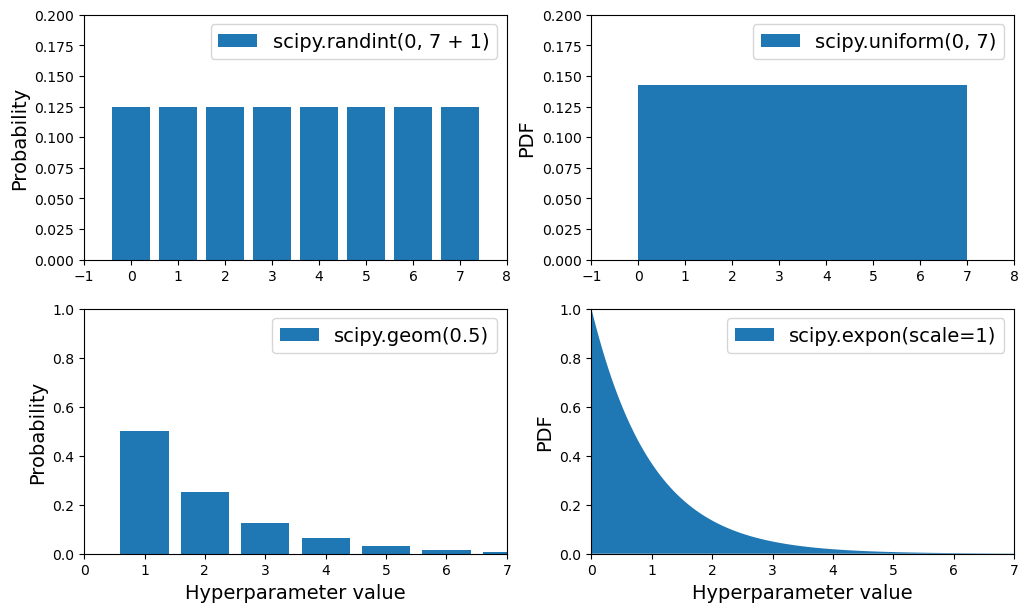

In [128]:
# extra code – plots a few distributions you can use in randomized search

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

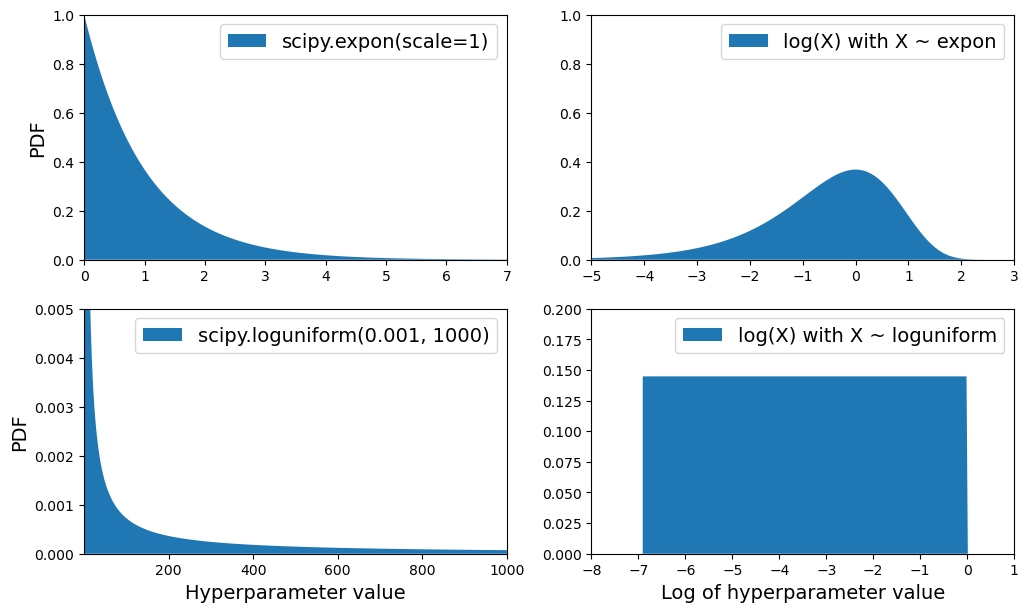

In [129]:
# extra code – shows the difference between expon and loguniform

from scipy.stats import loguniform

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
loguniform_distrib = loguniform(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_loguniform_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib,
                 label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib,
                 label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, loguniform_distrib,
                 label="scipy.loguniform(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_loguniform_distrib,
                 label="log(X) with X ~ loguniform")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()

### 7.3 集成方法（Ensemble Methods）

另一种微调系统的方法是尝试组合性能最好的模型。群体（或“集合”）通常会比最好的个体模型表现得更好——就像随机森林比它们所依赖的单个决策树表现得更好一样——特别是当单个模型犯了非常不同类型的错误时。例如，您可以训练和微调一个k近邻模型，然后创建一个集成模型，该模型只预测随机森林预测的平均值和该模型的预测。我们将在第7章中更详细地介绍这个主题。

### 7.4 分析最佳模型及其错误（Analyzing the Best Models and Their Errors）

通过检查最佳模型，您通常会获得对这个问题的良好见解。例如，随机森林回归变量可以表明每个属性对做出准确预测的相对重要性：

In [130]:
final_model = rnd_search.best_estimator_  # includes preprocessing

feature_importances = final_model["random_forest"].feature_importances_

feature_importances.round(2)

array([0.06, 0.05, 0.06, 0.01, 0.01, 0.01, 0.01, 0.18, 0.02, 0.  , 0.03,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.02, 0.01,
       0.02, 0.01, 0.01, 0.01, 0.01, 0.04, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.03, 0.  , 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

让我们按降序排序这些重要性分数，并将它们显示在它们相应的属性名旁边：

In [131]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.17794100819751724, 'log__median_income'),
 (0.07357280480971609, 'cat__ocean_proximity_INLAND'),
 (0.05659873649606716, 'people_per_house__ratio'),
 (0.05553886404457024, 'bedrooms__ratio'),
 (0.05051757224275048, 'rooms_per_house__ratio'),
 (0.04440649490825365, 'geo__Cluster 30 similarity'),
 (0.030936642133655486, 'geo__Cluster 2 similarity'),
 (0.026049523999170442, 'geo__Cluster 43 similarity'),
 (0.020374374892719496, 'geo__Cluster 41 similarity'),
 (0.01906217876550728, 'geo__Cluster 23 similarity'),
 (0.01892034245973477, 'geo__Cluster 36 similarity'),
 (0.016667818534074605, 'geo__Cluster 0 similarity'),
 (0.016189968214745384, 'geo__Cluster 20 similarity'),
 (0.015072893759127752, 'geo__Cluster 25 similarity'),
 (0.014709839354144634, 'geo__Cluster 17 similarity'),
 (0.013930644502344826, 'geo__Cluster 27 similarity'),
 (0.013515903203222282, 'geo__Cluster 29 similarity'),
 (0.012534038184015581, 'geo__Cluster 9 similarity'),
 (0.012302193447242432, 'remainder__housing_me

有了这些信息，您可能想要尝试删除一些不太有用的特性（例如，显然只有一个 **ocean_proximity** 类别非常有用，所以您可以尝试删除其他的特性）。

**sklearn.featureselection.SelectFromModel** 转换器可以自动删除最没用的特性：当您 fit 时，它训练一个模型（通常是随机+森林），查看它的 **feature_importances_** 属性，并选择最有用的特性。然后，当您调用 **transform()** 时，它会删除其他特征。

您还应该看看您的系统所犯的具体错误，然后尝试理解为什么它会产生这些错误，以及什么可以解决这个问题：添加额外的特性或消除无信息的特性，清理异常值，等等。

现在也是一个很好的时机，以确保你的模型不仅适用，而且适用于所有类别的地区，无论是农村或城市，富人或穷人，北部或南部，少数民族，等等。为每个类别创建验证集的子集需要一些工作，但这是重要的：如果你的模型在整个地区的类别表现不佳，那么它可能不应该部署，直到问题得到解决，或者至少不应该用于预测这个类别，因为它可能弊大于利。

### 7.5 在测试集上评价系统（Evaluate Your System on the Test Set）

在调整了你的模型一段时间后，你最终就有了一个性能足够好的系统。您已经准备好在测试集上评估最终的模型了。这个过程没有什么特别之处；只要从测试集中获取 **predictors** 和 **labels** ，然后运行 **final_model** 来转换数据并做出预测，然后评估这些预测：

In [132]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)

print(final_rmse)

42619.91579321231


在某些情况下，这样一个泛化误差的点估计将不足以说服你启动：如果它只比目前正在生产的模型好0.1%，会怎么样呢？你可能想知道这个估计有多精确。为此，您可以使用 **scipy.stats.t.interval()** 计算泛化误差的95%置信区间。你得到一个相当大的区间，从39,275到43,467，你之前估计的41,424点大约在中间：

In [133]:
from scipy import stats

confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([40479.7092181 , 44657.67107742])

如果您做了大量的超参数调优，性能通常会比使用交叉验证测量的稍差。这是因为您的系统最终进行了微调，以在验证数据上表现良好，而在未知数据集上可能不会表现很好。在本例中不是这样，因为测试RMSE低于验证RMSE，但当它发生时，您必须抵制调整超参数的诱惑，使数字在测试集上看起来不错；改进不太可能推广到新数据。

现在是项目启动前阶段：您需要展示您的解决方案（突出显示您学到了什么，哪些有效，哪些无效，做出了哪些假设，以及您的系统的局限性），记录所有内容，并创建具有清晰可视化效果的漂亮演示文稿 以及易于记忆的陈述（例如，“收入中位数是房价的首要预测指标”）。 在这个加利福尼亚州的住房示例中，该系统的最终性能并不比专家的价格估计好多少，专家的价格估计通常要低 30%，但启动它可能仍然是一个好主意，尤其是如果这样对于专家来说可以腾出一些时间的话，这样他们就可以从事更有趣、更有成效的任务。

## 8. 启动、监控、维护您的系统（Launch, Monitor, and Maintain Your Syste）

您现在需要为生产过程中的解决方案做好准备（例如，修改代码，编写文档和测试，等等）。然后，您就可以将模型部署到生产环境中。最基本的方法是保存您所训练过的最佳模型，将文件传输到生产环境中，并加载它。要保存模型，您可以像这样使用joblib库：

In [134]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

保存你实验的每一个模型通常是一个好主意，这样你就可以轻松地回到任何你想要的模型。您还可以保存交叉验证分数，以及在验证集上的实际预测。这将允许您轻松地比较不同模型类型的分数，并比较它们所犯的错误类型。

一旦模型转移到生产环境中，您就可以加载并使用它。为此，您必须首先导入模型所依赖的任何自定义类和函数（这意味着将代码转移到生产产品中），然后使用joblib加载模型，并使用它来进行预测：

In [136]:
import joblib

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

predictions

array([463864.11, 103942.  ,  98938.  , 341999.02, 107788.  ])

例如，也许这个模型会在一个网站中使用：用户会输入一些关于一个新地区的数据，然后点击“估计价格”按钮。这将把一个包含数据的查询发送到web服务器，该服务器将把数据转发到您的web应用程序，最后您的代码将简单地调用模型的 **predict()** 方法（您希望在服务器启动时加载模型，而不是每次使用模型时）。或者，您可以将模型包装在一个专用的web服务中，您的web应用程序可以通过 **REST API** 进行查询，见下图。

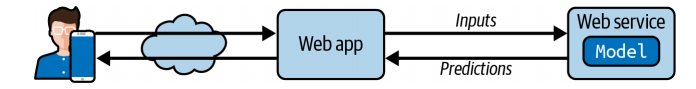

这使得在不中断主应用程序的情况下将模型升级到新版本更容易。它还简化了扩展，因为您可以根据需要启动尽可能多的web服务，并通过这些web服务来平衡来自web应用程序的请求。此外，它允许您的web应用程序使用任何编程语言，而不仅仅是Python。

另一个流行的策略是部署你的模型到云上，例如在谷歌的 **Vertex AI**（原名谷歌云AI平台和谷歌云ML引擎）：只是使用 **joblib** 保存你的模型和上传到谷歌云存储（Google Cloud Storage，GCS），然后前往 Vertex AI 并创建一个新的模型版本，指向 GCS 文件。就这样！这为您提供了一个简单的web服务，它可以为您处理负载平衡和扩展。它接受包含输入数据（例如，一个地区的数据）的JSON请求，并返回包含预测的JSON响应。然后，您可以在您的网站（或您正在使用的任何生产环境）中使用这个web服务。正如您将在第19章中看到的，在 Vertex AI 上部署 TensorFlow 模型与部署 Scikit-Learn 模型没有太大区别。

但部署并不是故事的结局。您还需要编写监控代码来定期检查系统的实时性能，并在性能下降时触发警报。它可能会很快下降，例如，如果一个组件在您的基础设施中中断，但请注意，它也可能衰减非常缓慢，这很容易在很长一段时间内被忽视。这是很常见的，因为模型折旧：如果模型是用去年的数据进行训练的，它可能无法适应今天的数据。

因此，您需要监控模型的实时性能。但是你该怎么做呢？这取决于。在某些情况下，模型的性能可以从下游指标中推断出来。例如，如果您的模型是推荐系统的一部分，并且它建议用户可能感兴趣的产品，那么就很容易监控每天销售的推荐产品的数量。如果这个数字下降（与不推荐的产品相比），那么最主要的怀疑是模型。这可能是因为数据 pipeline 被破坏了，或者模型可能需要对新的数据进行再训练（我们稍后将会讨论一下）。

但是，您可能还需要进行人工分析来评估模型的性能。例如，假设您训练了一个图像分类模型（我们将在第3章中查看这些模型）来检测生产线上的各种产品缺陷。如果模型的性能下降，在成千上万的缺陷产品运给你的客户之前，你如何得到警报？一种解决方案是将模型分类的所有图片（特别是模型不太确定的图片）的样本发送给人类评分员。根据任务的不同，评分者可能需要是专家，也可能是非专家，比如在众包平台（如Amazon Mechanical Turk）上的工人。在一些应用程序中，它们甚至可以是用户自己，例如，通过调查或重新使用的验证码做出响应。

无论哪种方式，您都需要建立一个监控系统（是否有人工评估员来评估实时模型），以及所有相关流程来定义在发生故障时应该做什么以及如何做好准备。不幸的是，这可能需要做很多工作。事实上，这通常比建立和训练一个模型要工作多得多。

如果数据不断发展，您将需要更新您的数据集，并定期重新训练您的模型。你可能应该尽可能多地自动化整个过程。以下是一些你可以自动化的事情：

1. 定期收集新的数据，并将其贴上标签（例如，使用人工评分员）。
2. 编写一个脚本来训练模型，并自动微调超参数。这个脚本可以自动运行，例如，每天或每周，根据您的需要。
2. 编写另一个脚本，在更新的测试集上评估新模型和前一个模型，如果性能没有减少，则部署生产模型（如果没有减少，请确保调查原因）。该脚本可能应该在测试集的各个子集上测试模型的性能，如贫困或富裕地区、农村或城市地区等。

您还应该确保您评估了模型的输入数据质量。有时，由于信号质量差（例如，故障传感器发送随机值，或其他团队的输出过时），性能会略有下降，但可能需要一段时间才能下降到足以触发警报。如果您监视模型的输入，您可能会更早地捕捉到这一点。例如，如果越来越多的输入缺少某个特性，或者平均值或标准偏差偏离训练集太远，或者分类特征开始包含新类别，则可以触发警报。

最后，确保您保留创建的每个模型的备份，并有流程和工具快速回滚到以前的模型，以防新模型由于某种原因严重失败。有备份还可以很容易地将新型号与以前的型号进行比较。类似地，您应该保留数据集的每个版本的备份，这样如果新数据集损坏（例如，如果添加到它的新数据充满了异常值），您就可以回滚到以前的数据集。对数据集的备份还允许您根据以前的任何数据集来评估任何模型。

正如您所看到的，机器学习涉及到相当多的基础设施。第19章讨论了这方面的一些方面，但它是一个非常广泛的主题，称为 **ML运维（MLOps）** ，它值得有它自己的书。因此，如果您的第一个ML项目需要大量的精力和时间来构建和部署到生产中，请不要感到惊讶。幸运的是，一旦所有的基础设施都到位了，从想法到生产将会快得多。

## 9. 试试吧（Try It Out!）

希望这一章能让你好好了解一个机器学习项目的样子，并向你展示一些你可以用它来训练一个伟大的系统的工具。正如您所看到的，大部分工作都是在数据准备步骤中进行的：构建监控工具、设置人工评估pipeline，以及自动化定期的模型训练。当然，机器学习算法很重要，但最好是熟悉整个过程，熟悉三四种算法，而不是花所有的时间探索高级算法。

所以，如果你还没有这样做，现在是一个很好的时间拿起笔记本电脑，选择一个你感兴趣的数据集，并尝试整个过程.一个好的地方是在竞争网站如Kaggle：你会有一个数据集玩，一个明确的目标，和人们分享经验。玩得开心！